In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Read in the dataset
df = pd.read_csv('/content/grocery sales.csv')

In [3]:
df.head()

Item  Order Date      Sales       Profit
0              Salt  11/08/2017  235601.52   75392.4864
1     Health_Drinks  11/08/2017  140722.12   28144.4240
2             Flour  06/12/2017  443396.80   31037.7760
3  Fresh_Vegetables  10/11/2016  168340.48   16834.0480
4   Organic_Staples  10/11/2016  442457.40  172558.3860

In [4]:
new_df = pd.DataFrame(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Item        9994 non-null   object 
 1   Order Date  9994 non-null   object 
 2   Sales       9994 non-null   float64
 3   Profit      9994 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.4+ KB


In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

In [7]:
# Sort by order date
df.sort_values(by=['Order Date'], inplace=True, ascending=True)

In [8]:
# Reset index as Order Date
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-04', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-06', '2015-01-06',
               '2015-01-06', '2015-01-06',
               ...
               '2018-12-29', '2018-12-29', '2018-12-29', '2018-12-30',
               '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30',
               '2018-12-30', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=9994, freq=None)

In [9]:
# Check for nulls
df.isnull().mean()*100

Item      0.0
Sales     0.0
Profit    0.0
dtype: float64

**Data Visualization**

In [10]:
# Sort the top 10 items by sales
top_items = df.groupby(['Item']).sum().sort_values('Sales', ascending=False).head(10)
top_items = top_items[['Sales']].round(2)
top_items.reset_index(inplace=True)

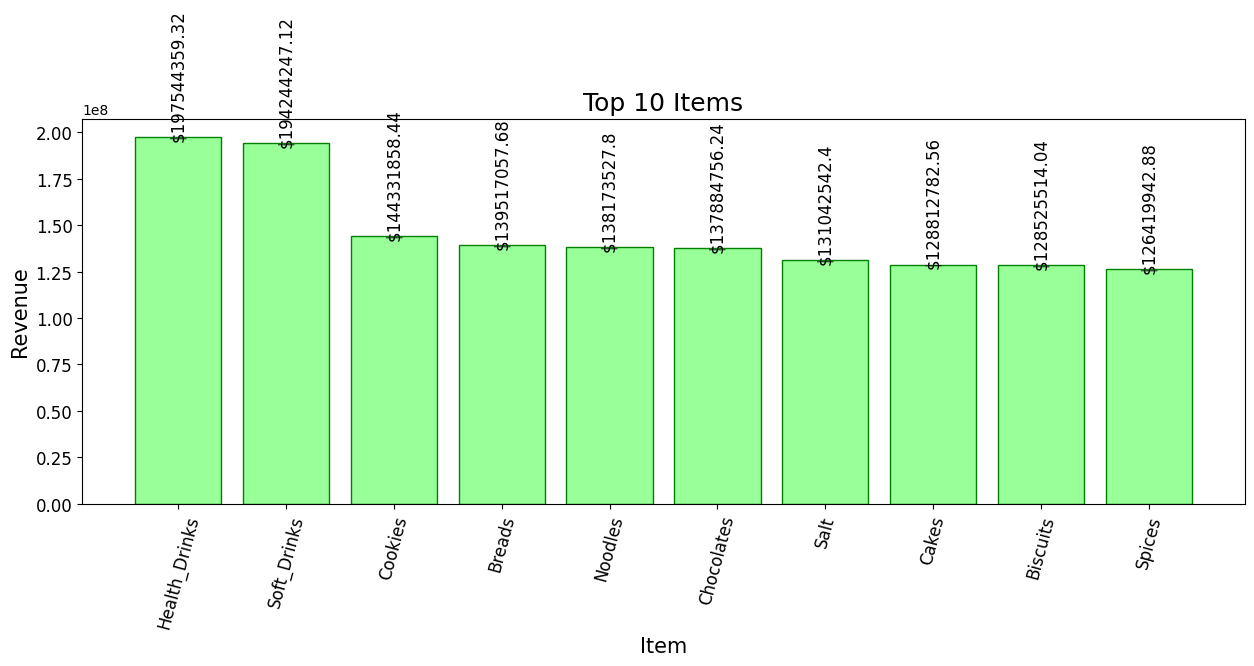

In [11]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Top 10 Items", fontsize=18)
plt.bar(top_items["Item"], top_items["Sales"],color= '#99ff99',edgecolor='green', linewidth = 1)
plt.xlabel("Item",fontsize=15) # x axis shows the items
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=75)
plt.yticks(fontsize=12)
for k,v in top_items["Sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-8000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

**Select Sales to Forecast**

In [12]:
# Select dataframe
temp_df = df
resample = 'MS'

**Separate DataFrame by Items**

In [13]:
#distinc the items
items = df['Item'].drop_duplicates(keep = 'first')
print(items)

Order Date
2015-01-03                Breads
2015-01-04                 Cakes
2015-01-04         Health_Drinks
2015-01-04            Chocolates
2015-01-05                  Fish
2015-01-06                  Salt
2015-01-06               Noodles
2015-01-06               Cookies
2015-01-06    Organic_Vegetables
2015-01-06                 Flour
2015-01-06            Edible_Oil
2015-01-07               Chicken
2015-01-07              Biscuits
2015-01-09               Legumes
2015-01-09                Spices
2015-01-11          Fresh_Fruits
2015-01-13                  Rice
2015-01-16                  Meat
2015-01-18       Organic_Staples
2015-01-20      Fresh_Vegetables
2015-01-20        Organic_Fruits
2015-01-20           Soft_Drinks
2015-01-20                  Eggs
Name: Item, dtype: object


In [14]:
# Create a dictionary to store DataFrames for each item
dfs = {}
#make a new df for every items
for item in items:
    item_df = pd.DataFrame(df.loc[df['Item'] == item]).copy
    dfs[item] = item_df
#print every item's df
for item, item_df in dfs.items():
    print(f"DataFrame for {item}:")
    print(item_df)
    print("\n")

DataFrame for Breads:
<bound method NDFrame.copy of               Item      Sales       Profit
Order Date                                
2015-01-03  Breads  162328.32   71424.4608
2015-01-19  Breads  414275.40  153281.8980
2015-01-20  Breads  345699.20  107166.7520
2015-02-04  Breads   96194.56   41363.6608
2015-02-11  Breads  333299.12   59993.8416
...            ...        ...          ...
2018-12-23  Breads  168716.24   10122.9744
2018-12-23  Breads  326159.68   55447.1456
2018-12-25  Breads  242365.20   75133.2120
2018-12-25  Breads  241237.92   55484.7216
2018-12-28  Breads  255892.56   71649.9168

[502 rows x 3 columns]>


DataFrame for Cakes:
<bound method NDFrame.copy of              Item      Sales       Profit
Order Date                               
2015-01-04  Cakes  381960.04   61113.6064
2015-01-13  Cakes  201595.24   24191.4288
2015-01-20  Cakes  441518.00  150116.1200
2015-01-20  Cakes  144103.96   15851.4356
2015-02-14  Cakes  239547.00   98214.2700
...           ...

In [15]:
def lstm_preprocessing(df, resample='MS'):
    # Resulting dataframe will be two columns, Order Date and Sales sorted by date
    df = df.sort_values('Order Date')
    df = df.groupby('Order Date')['Sales'].sum().reset_index()
    df = df.set_index('Order Date')
    y_df = df['Sales'].resample(resample).mean()
    df = pd.DataFrame({'Order Date': y_df.index, 'Sales': y_df.values})

    # Remove rows with NaN values in the 'Sales' column
    df = df.dropna(subset=['Sales'])

    return df

In [16]:
# Preprocess our individual dataframes
sales_df = lstm_preprocessing(df, resample)
dfs['Breads'] = lstm_preprocessing(dfs['Breads'](), resample)
dfs['Cakes'] = lstm_preprocessing(dfs['Cakes'](), resample)
dfs['Health_Drinks'] = lstm_preprocessing(dfs['Health_Drinks'](), resample)
dfs['Chocolates'] = lstm_preprocessing(dfs['Chocolates'](), resample)
dfs['Fish'] = lstm_preprocessing(dfs['Fish'](), resample)
dfs['Salt'] = lstm_preprocessing(dfs['Salt'](), resample)
dfs['Noodles'] = lstm_preprocessing(dfs['Noodles'](), resample)
dfs['Cookies'] = lstm_preprocessing(dfs['Cookies'](), resample)
dfs['Organic_Vegetables'] = lstm_preprocessing(dfs['Organic_Vegetables'](), resample)
dfs['Flour'] = lstm_preprocessing(dfs['Flour'](), resample)
dfs['Edible_Oil'] = lstm_preprocessing(dfs['Edible_Oil'](), resample)
dfs['Chicken'] = lstm_preprocessing(dfs['Chicken'](), resample)
dfs['Biscuits'] = lstm_preprocessing(dfs['Biscuits'](), resample)
dfs['Legumes'] = lstm_preprocessing(dfs['Legumes'](), resample)
dfs['Spices'] = lstm_preprocessing(dfs['Spices'](), resample)
dfs['Fresh_Fruits'] = lstm_preprocessing(dfs['Fresh_Fruits'](), resample)
dfs['Rice'] = lstm_preprocessing(dfs['Rice'](), resample)
dfs['Meat'] = lstm_preprocessing(dfs['Meat'](), resample)
dfs['Organic_Staples'] = lstm_preprocessing(dfs['Organic_Staples'](), resample)
dfs['Fresh_Vegetables'] = lstm_preprocessing(dfs['Fresh_Vegetables'](), resample)
dfs['Organic_Fruits'] = lstm_preprocessing(dfs['Organic_Fruits'](), resample)
dfs['Soft_Drinks'] = lstm_preprocessing(dfs['Soft_Drinks'](), resample)
dfs['Eggs'] = lstm_preprocessing(dfs['Eggs'](), resample)

In [17]:
print (dfs['Fish'])

   Order Date          Sales
0  2015-01-01  271486.600000
1  2015-02-01  446872.580000
2  2015-03-01  361180.512000
3  2015-04-01  297151.008000
4  2015-05-01  284713.352000
5  2015-06-01  501940.208000
6  2015-07-01  288132.768000
8  2015-09-01  270797.706667
9  2015-10-01  230129.515000
10 2015-11-01  355155.826667
11 2015-12-01  358224.533333
12 2016-01-01  201407.360000
13 2016-02-01  206855.880000
14 2016-03-01  312663.633333
15 2016-04-01  320222.672000
16 2016-05-01  270860.333333
17 2016-06-01  445980.150000
18 2016-07-01  316358.606667
19 2016-08-01  332547.600000
20 2016-09-01  333017.300000
21 2016-10-01  308624.213333
22 2016-11-01  289376.951111
23 2016-12-01  400338.120000
25 2017-02-01  191543.660000
26 2017-03-01  294783.720000
27 2017-04-01  444054.380000
28 2017-05-01  416529.960000
29 2017-06-01  363265.980000
30 2017-07-01  282414.953333
31 2017-08-01  155235.850000
32 2017-09-01  319114.180000
33 2017-10-01  442927.100000
34 2017-11-01  295591.604000
35 2017-12-01 

In [57]:
def run_lstm(name, df, epochs=500, batch_size=64):
    # Format the data specifically for the LSTM model
    lstm_df = df[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

    # Normalize the data
    scaler = MinMaxScaler()
    lstm_df['y'] = scaler.fit_transform(lstm_df['y'].values.reshape(-1, 1))

    # Create sequences for LSTM
    X, y = create_sequences(lstm_df['y'].values)

    # Expand dimensions to match the LSTM input shape (batch_size, lookback, 1)
    X = np.expand_dims(X, axis=-1)

    # Split the data into training and testing sets
    split_index = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

    # Build the LSTM model
    model = build_lstm_model()

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

    # Save the model
    model.save(f'{name}_lstm_model.h5')

   # Show the results
    plt.figure(figsize=(18, 6))
    plt.plot(lstm_df['ds'], scaler.inverse_transform(lstm_df['y'].to_numpy().reshape(-1, 1)).flatten(), label='Actual', marker='o')
    plt.plot(lstm_df['ds'][split_index:split_index+len(X_test)], scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).flatten(), label='Predicted', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'{name} Sales')
    plt.legend()
    plt.show()

    # Normalize future sales data using the same scaler
    future_dates = pd.date_range(start=df['Order Date'].max()+pd.DateOffset(1), periods=6, freq='M')
    future_data = pd.DataFrame({'Order Date': future_dates})

    # Use the actual sales values for the initial values in future_data
    future_data['Sales'] = df['Sales'].values[-1]

    # Normalize the initial sales value using the same scaler
    future_data['Sales'] = scaler.transform(future_data['Sales'].values.reshape(-1, 1))

    # Create sequences for future data with more variability
    if len(future_data) >= 1:  # Assuming lookback is always 1
        # Add some variability to initial sequences
        initial_sequences = [future_data['Sales'].values[i:i + 1] for i in range(len(future_data) - 1 + 1)]
        variability_factor = 0.05  # Adjust as needed
        initial_sequences = [seq + np.random.normal(0, variability_factor, size=1) for seq in initial_sequences]
        X_future = np.array(initial_sequences)

    future_predictions = []

    # Iteratively predict future values
    for i in range(len(future_dates)):
        prediction = model.predict(X_future[i:i + 1])
        future_predictions.append(prediction[0, 0])
        # Update X_future with the latest prediction
        X_future = np.roll(X_future, shift=-1, axis=1)
        X_future[:, -1] = prediction[0, 0]

    # Inverse transform to get the actual sales values
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

    # Plot the results
    plt.figure(figsize=(18, 6))
    plt.plot(lstm_df['ds'], scaler.inverse_transform(lstm_df['y'].to_numpy().reshape(-1, 1)).flatten(), label='Actual', marker='o')
    plt.plot(future_dates, future_predictions, label='Future Predictions', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Sales Prediction for Future Dates')
    plt.legend()
    plt.show()

def create_sequences(data):
    sequences = []
    for i in range(len(data) - 1):
        sequence = data[i]
        target = data[i + 1]
        sequences.append((sequence, target))
    X, y = zip(*sequences)
    return np.array(X), np.array(y)


def build_lstm_model():
    model = Sequential()
    model.add(LSTM(500, activation='relu', input_shape=(1, 1), kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



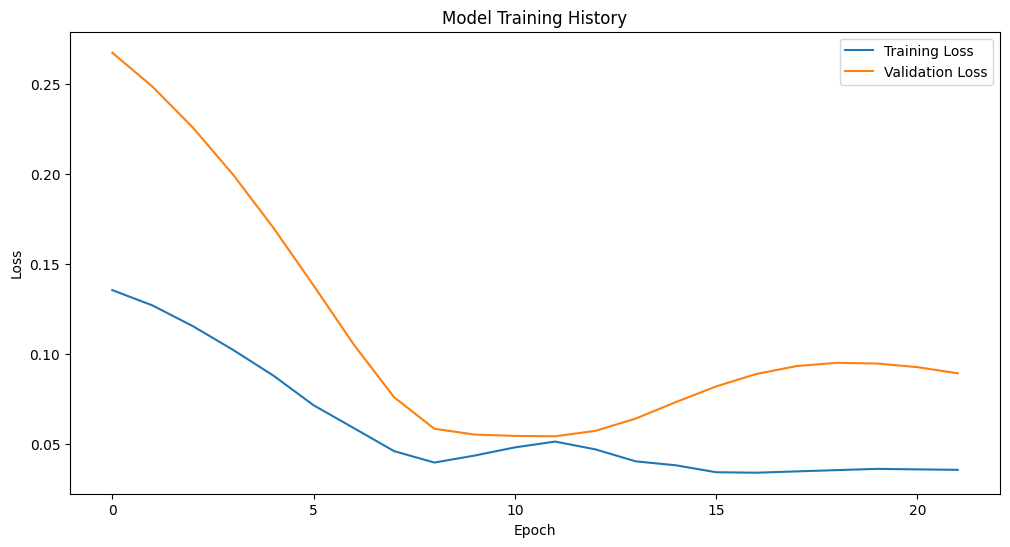

1/1 [==============================] - 0s 111ms/step - loss: 0.0798
Test Loss: 0.07984936237335205


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 781ms/step


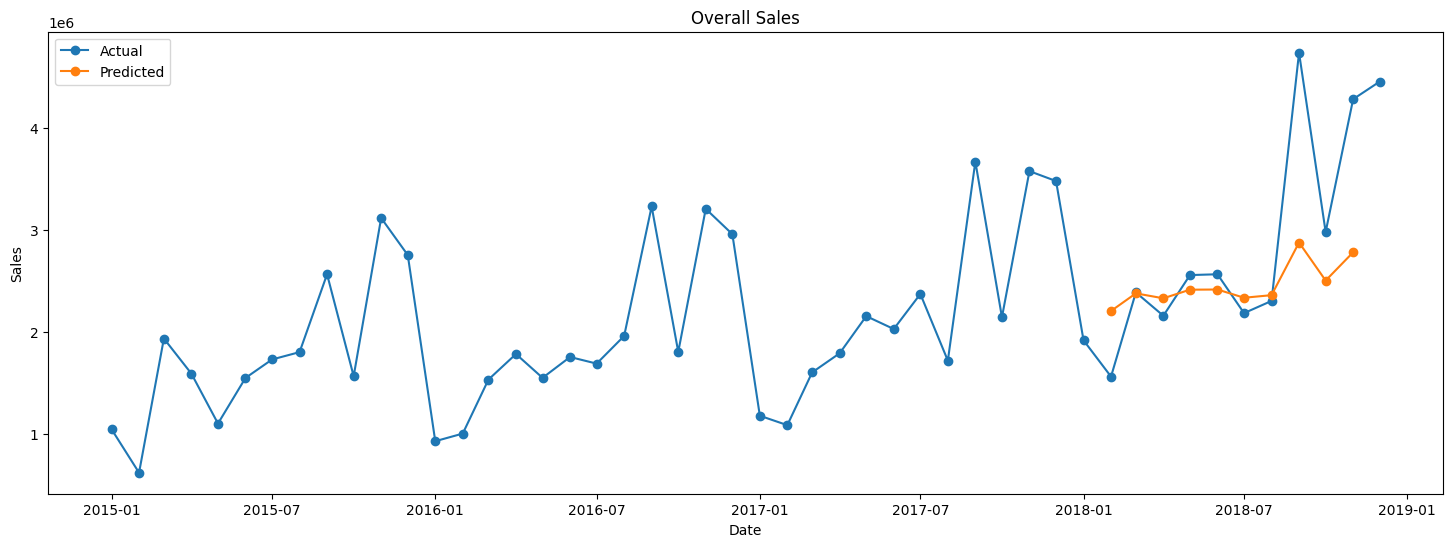

1/1 [==============================] - 0s 38ms/step


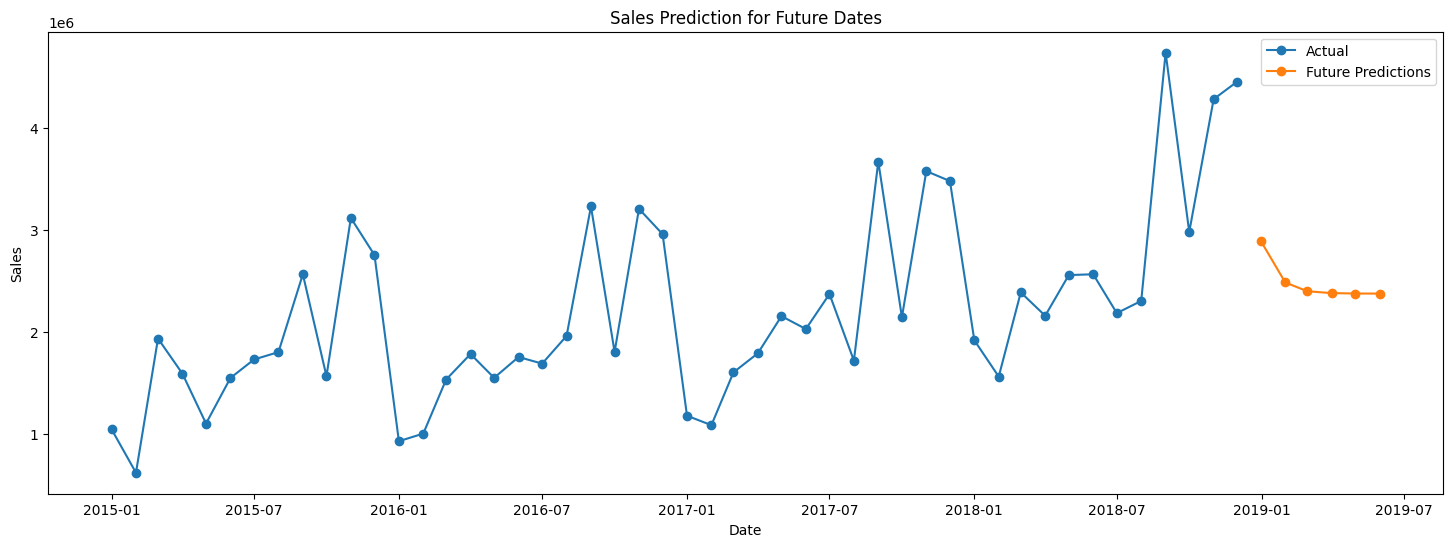

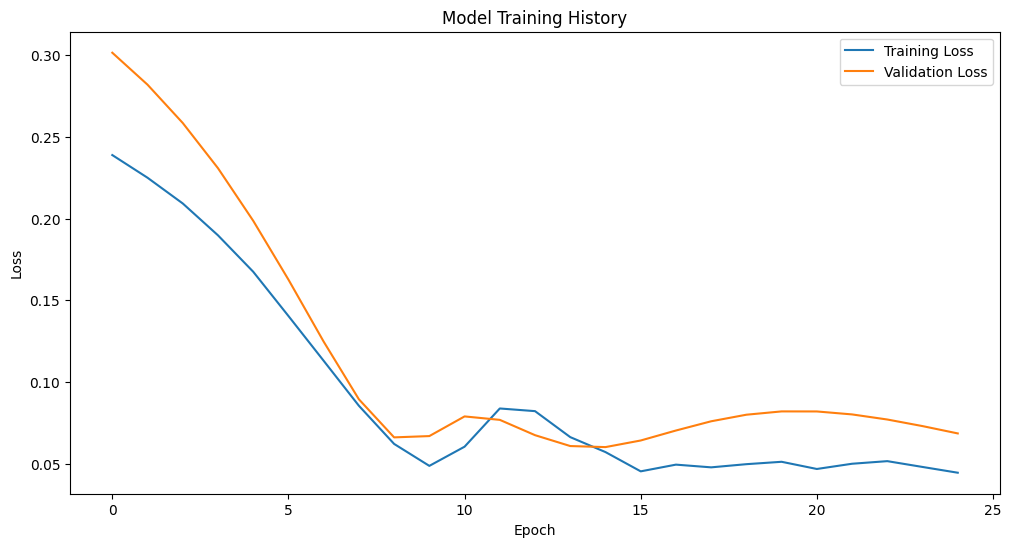

1/1 [==============================] - 0s 65ms/step - loss: 0.0698
Test Loss: 0.06979797780513763


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 534ms/step


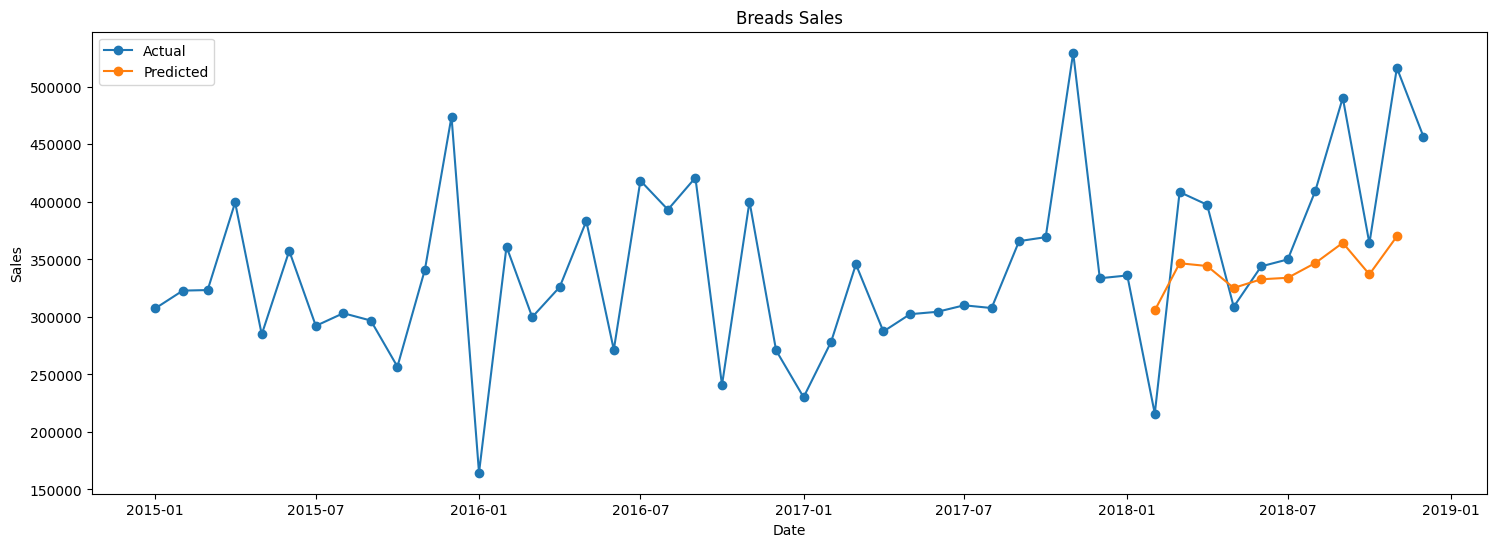

1/1 [==============================] - 0s 38ms/step


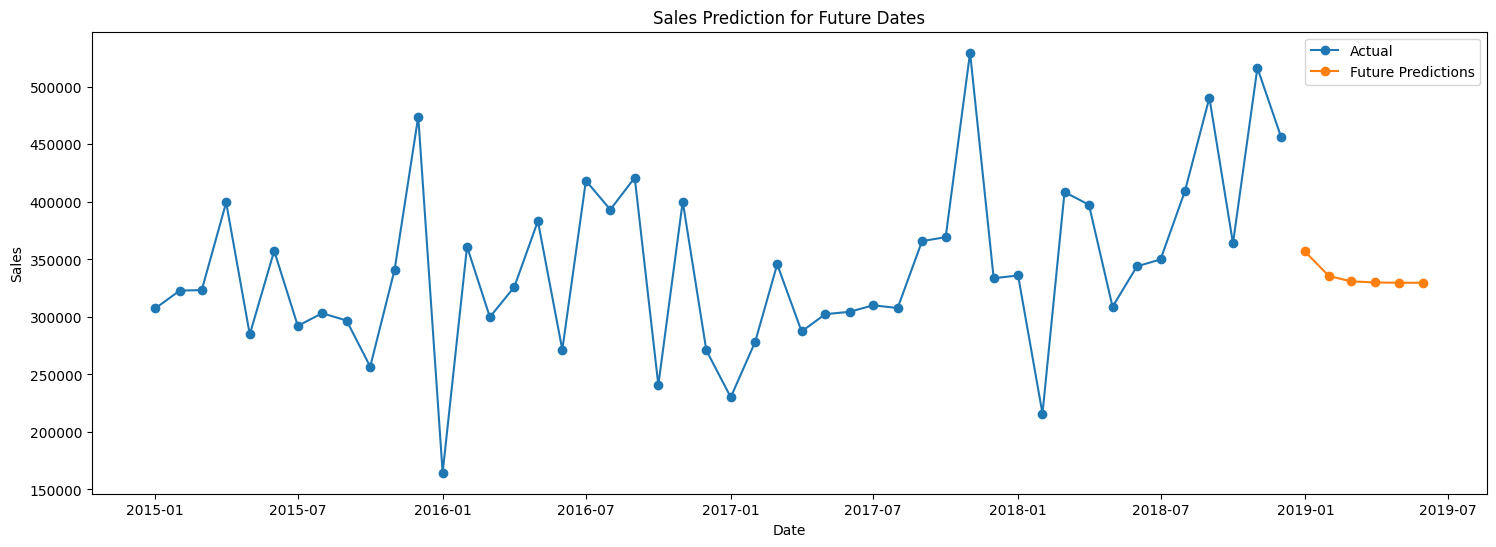

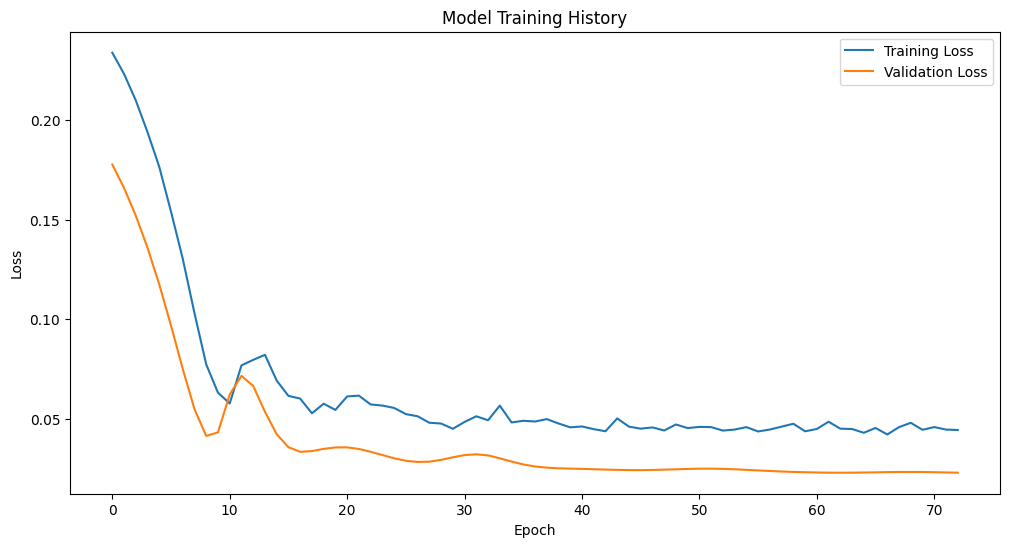

1/1 [==============================] - 0s 30ms/step - loss: 0.0779
Test Loss: 0.07793054729700089


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 228ms/step


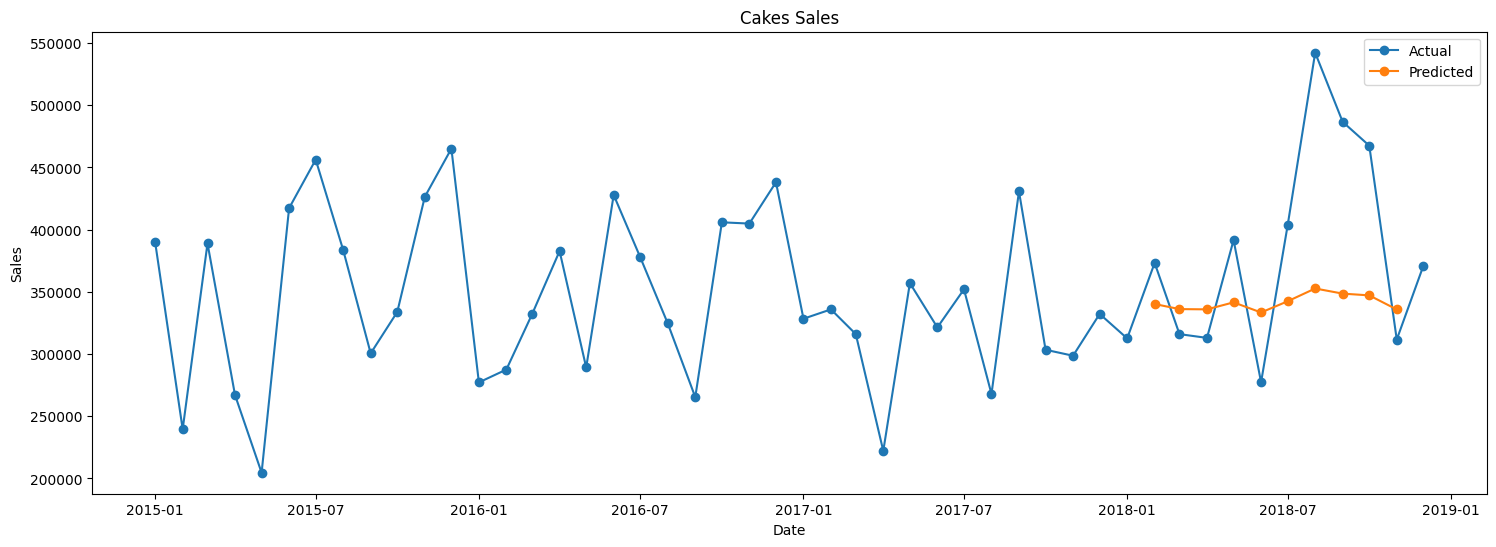

1/1 [==============================] - 0s 22ms/step


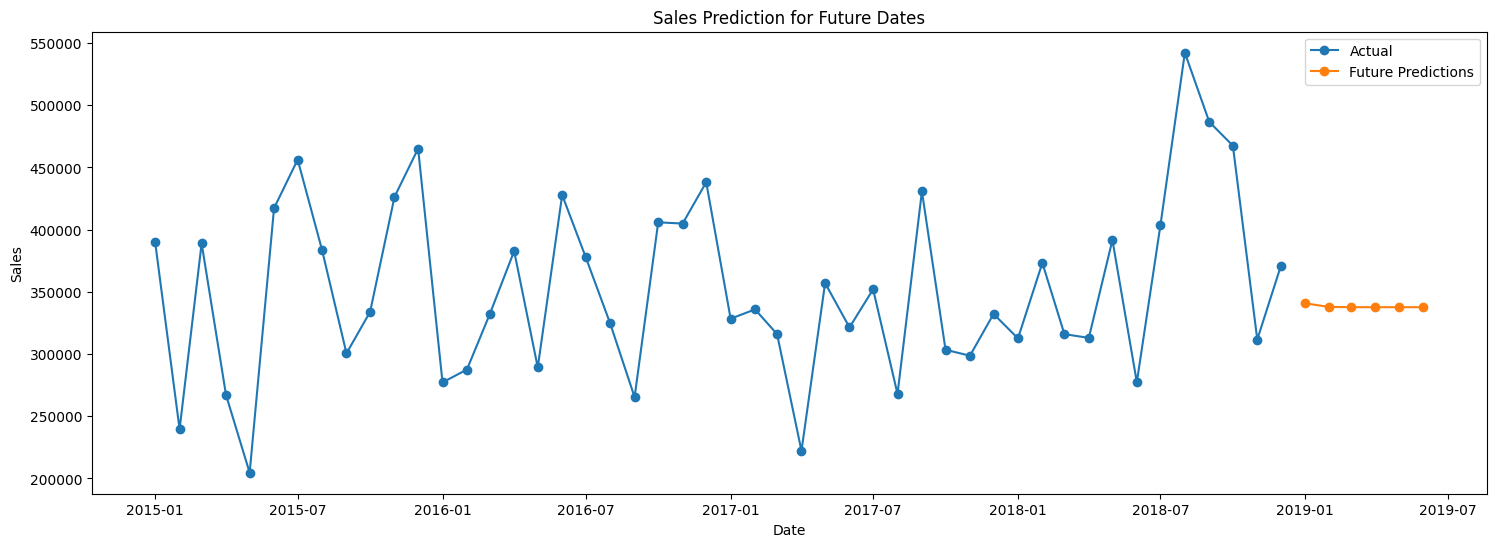

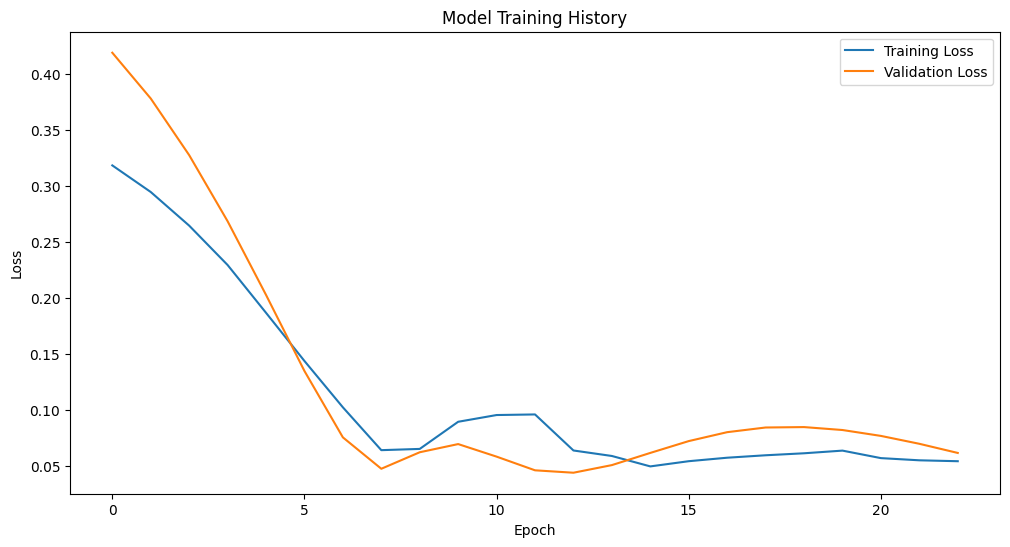

1/1 [==============================] - 0s 30ms/step - loss: 0.0358
Test Loss: 0.03575868532061577


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 268ms/step


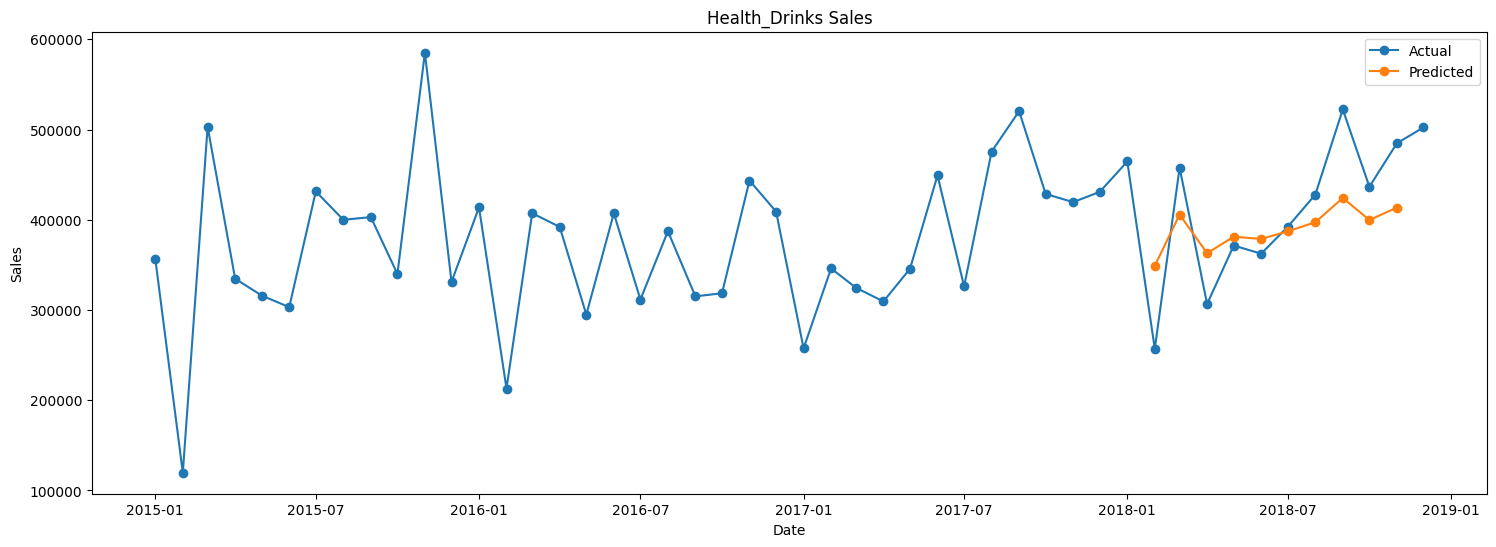

1/1 [==============================] - 0s 34ms/step


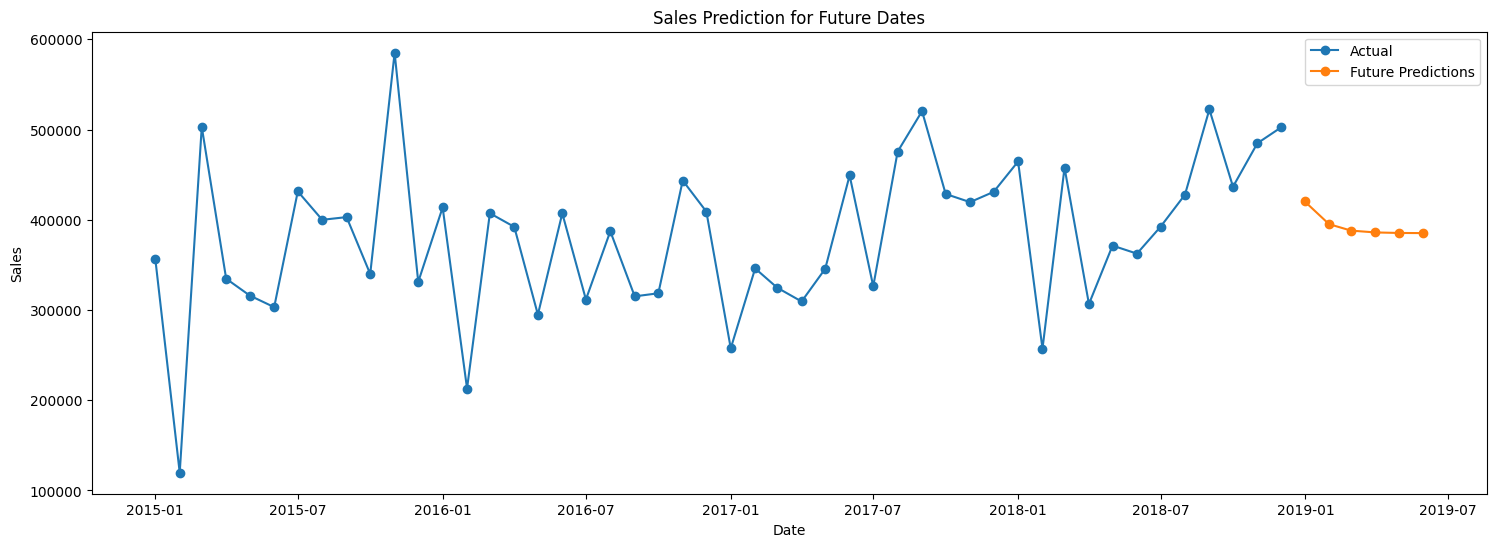

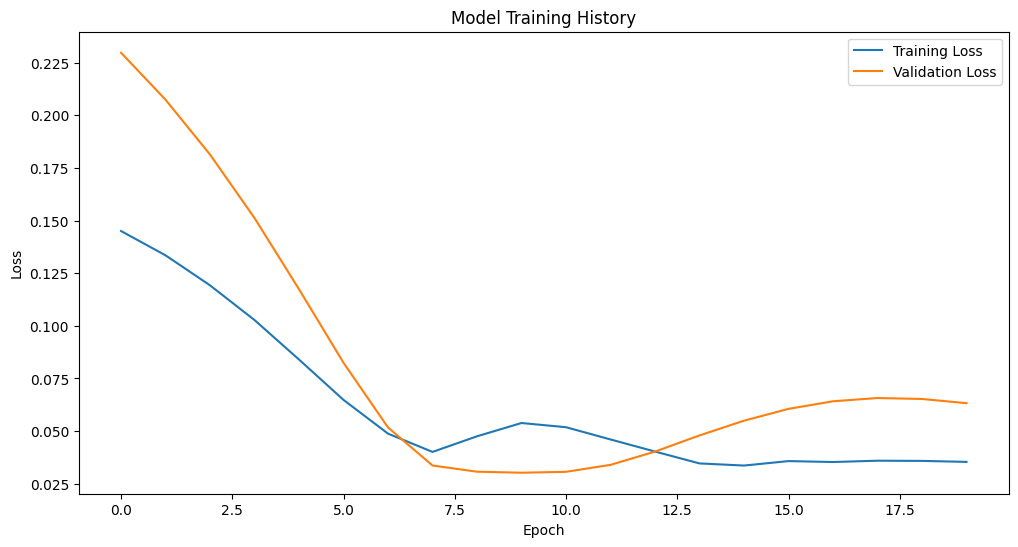

1/1 [==============================] - 0s 40ms/step - loss: 0.0567
Test Loss: 0.056674472987651825


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 283ms/step


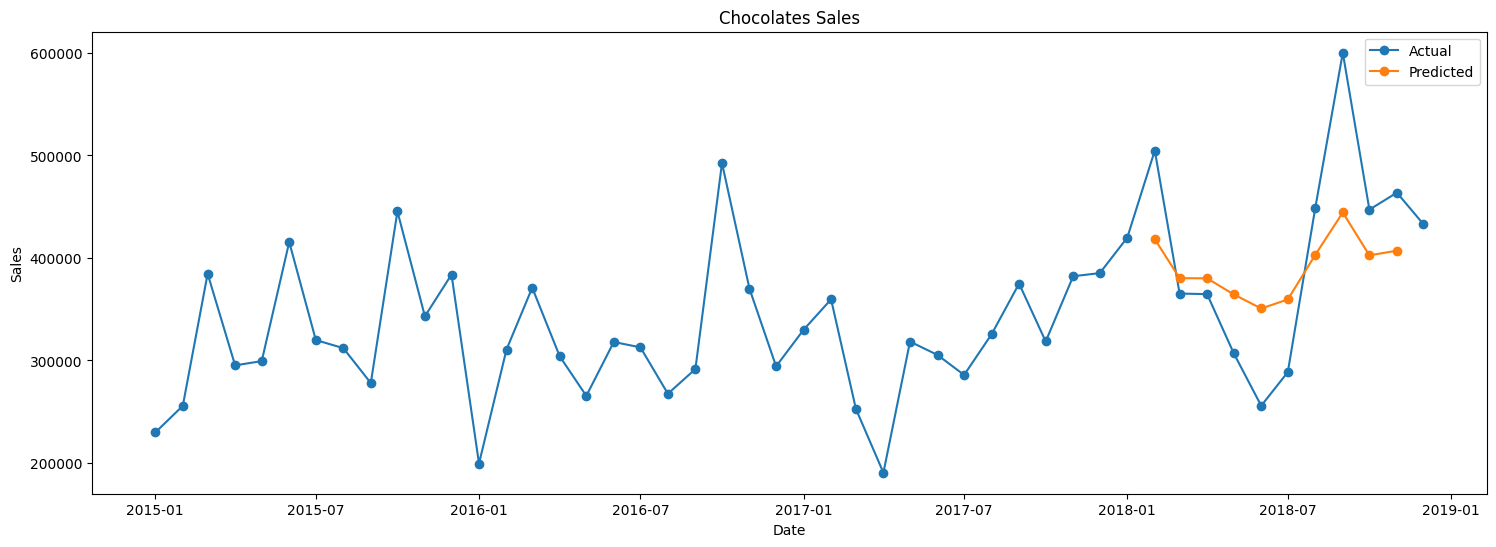

1/1 [==============================] - 0s 27ms/step


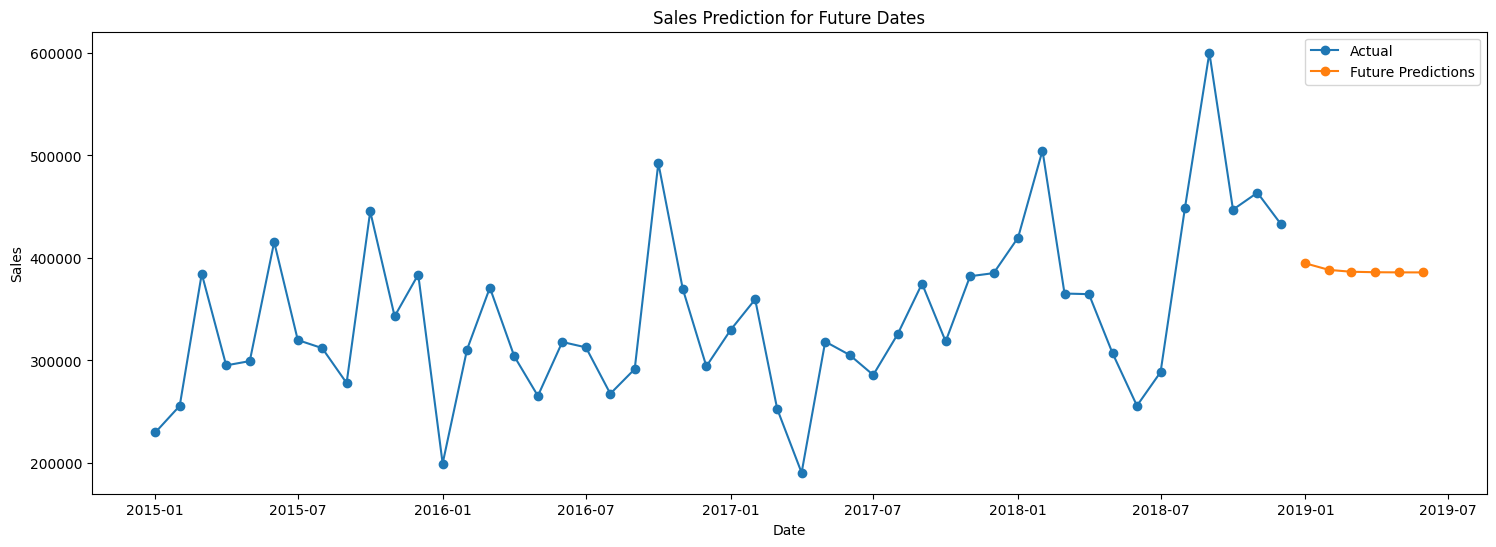

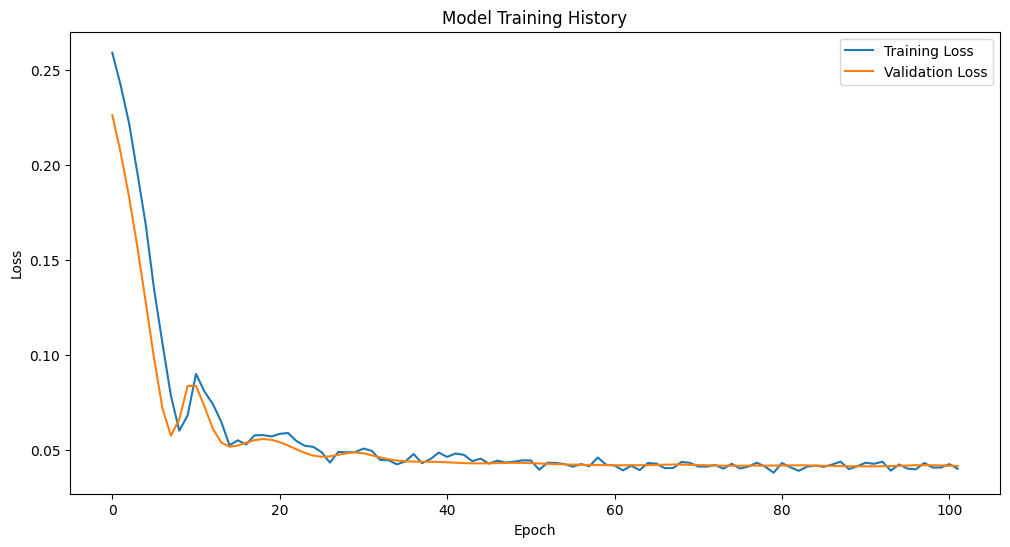

1/1 [==============================] - 0s 33ms/step - loss: 0.0798
Test Loss: 0.0797508955001831


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 245ms/step


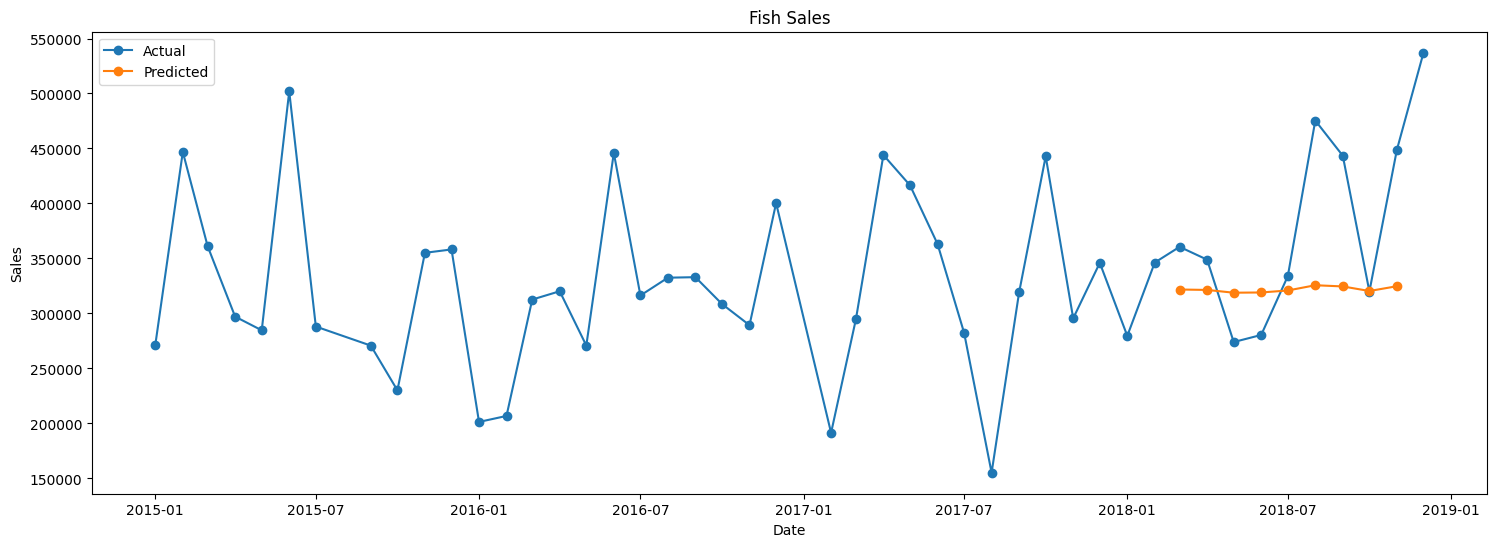

1/1 [==============================] - 0s 23ms/step


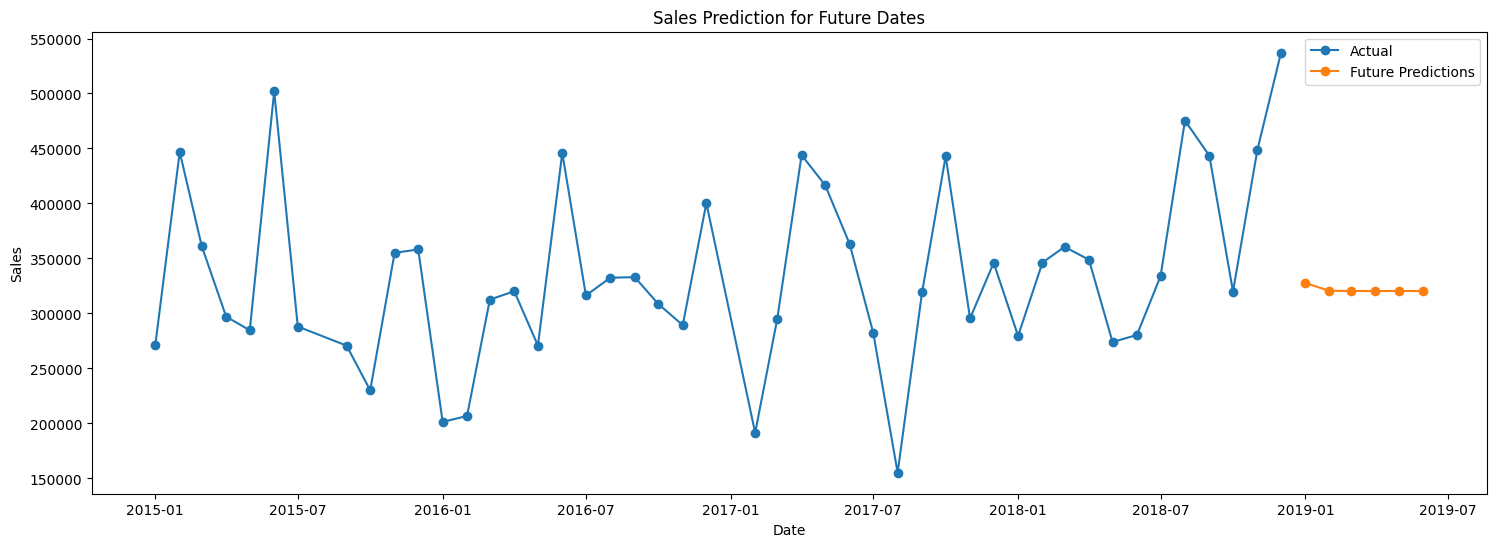

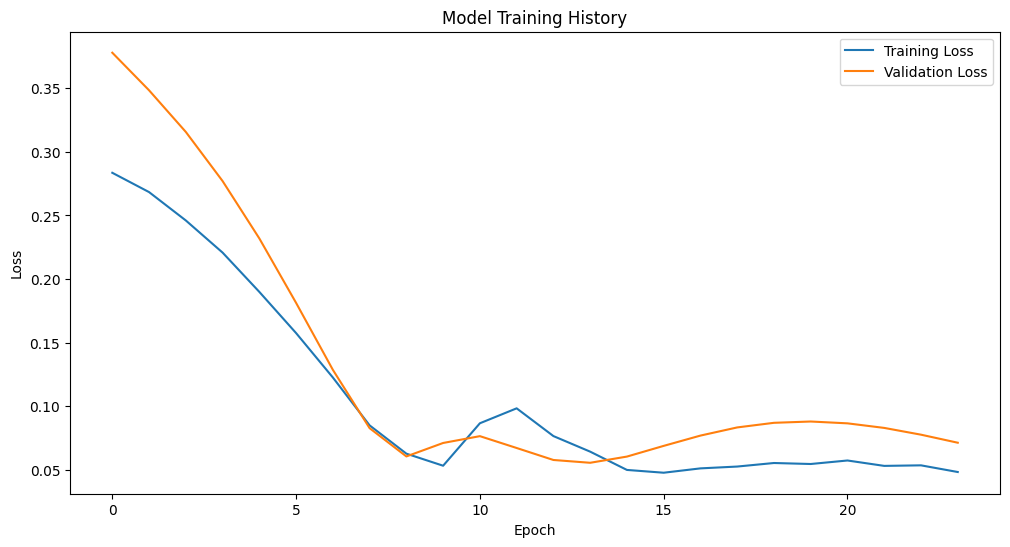

1/1 [==============================] - 0s 52ms/step - loss: 0.0568
Test Loss: 0.056774139404296875


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 335ms/step


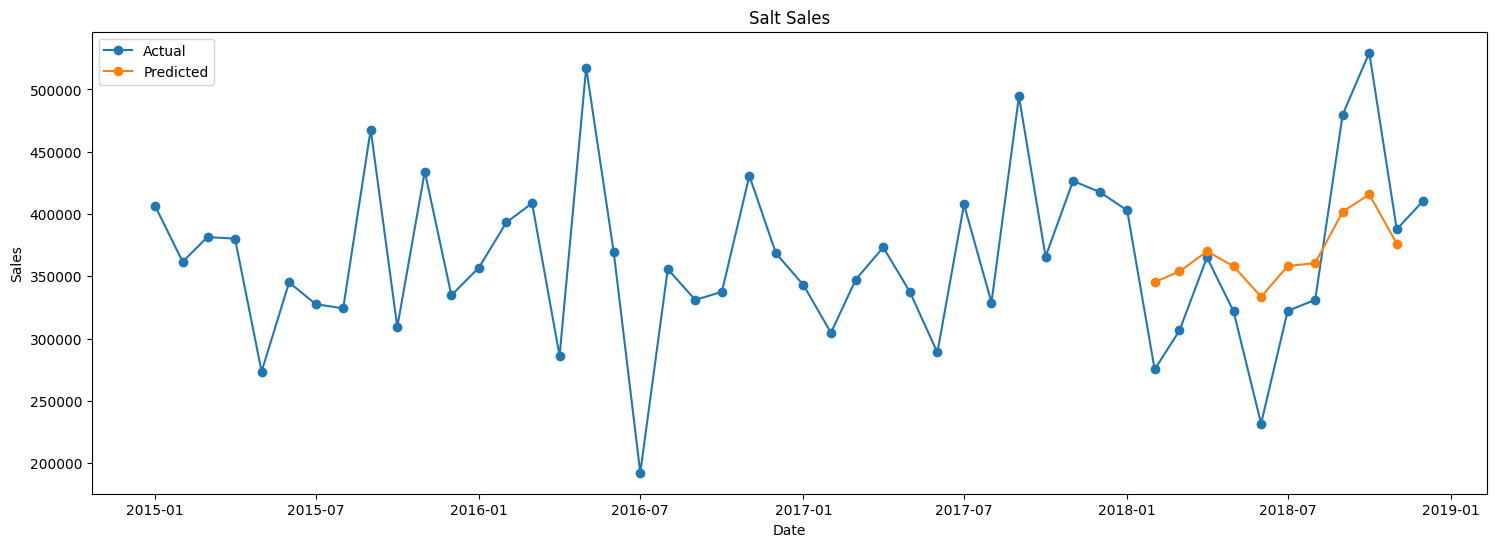

1/1 [==============================] - 0s 26ms/step


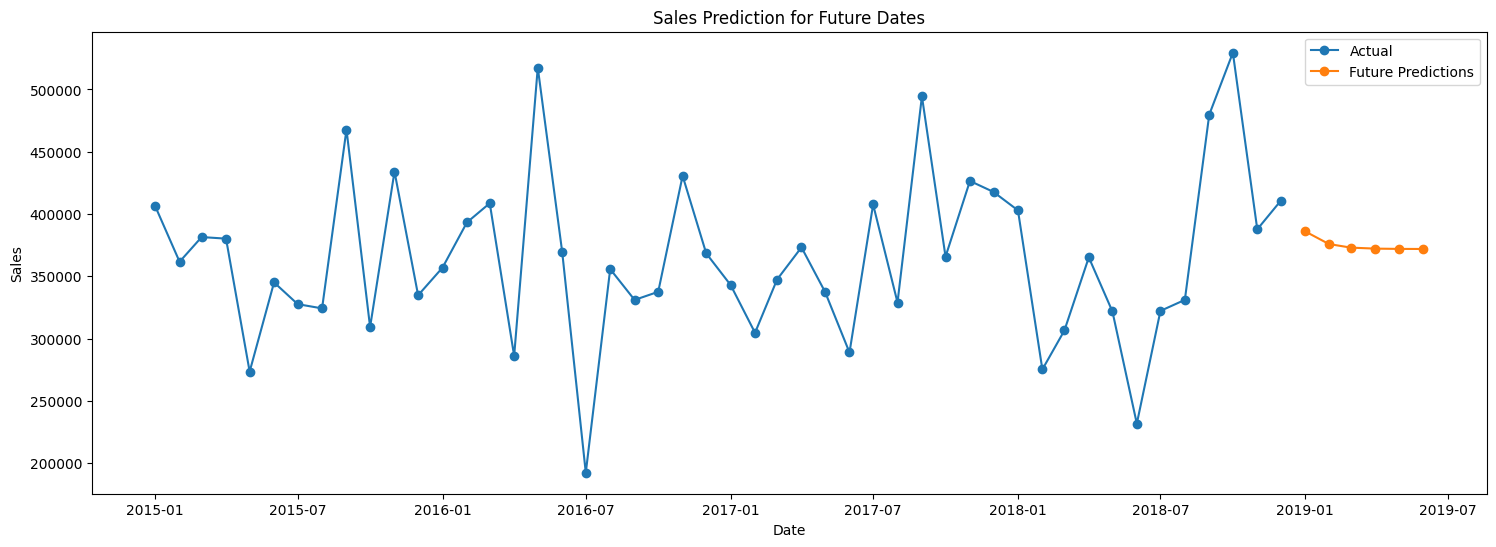

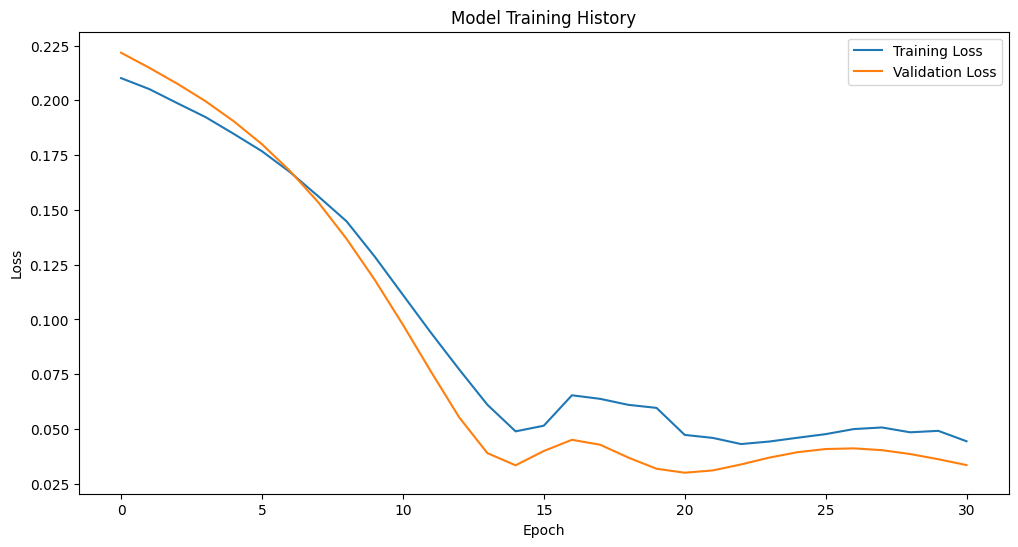

1/1 [==============================] - 0s 28ms/step - loss: 0.0446
Test Loss: 0.0445951372385025


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 241ms/step


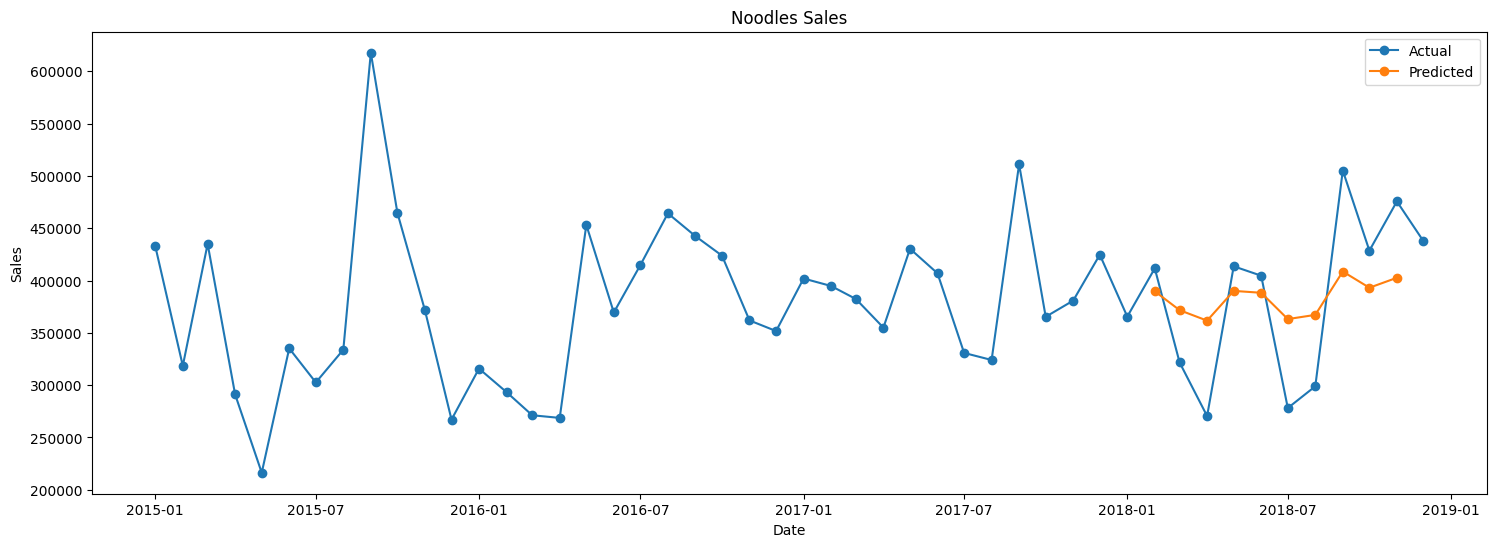

1/1 [==============================] - 0s 25ms/step


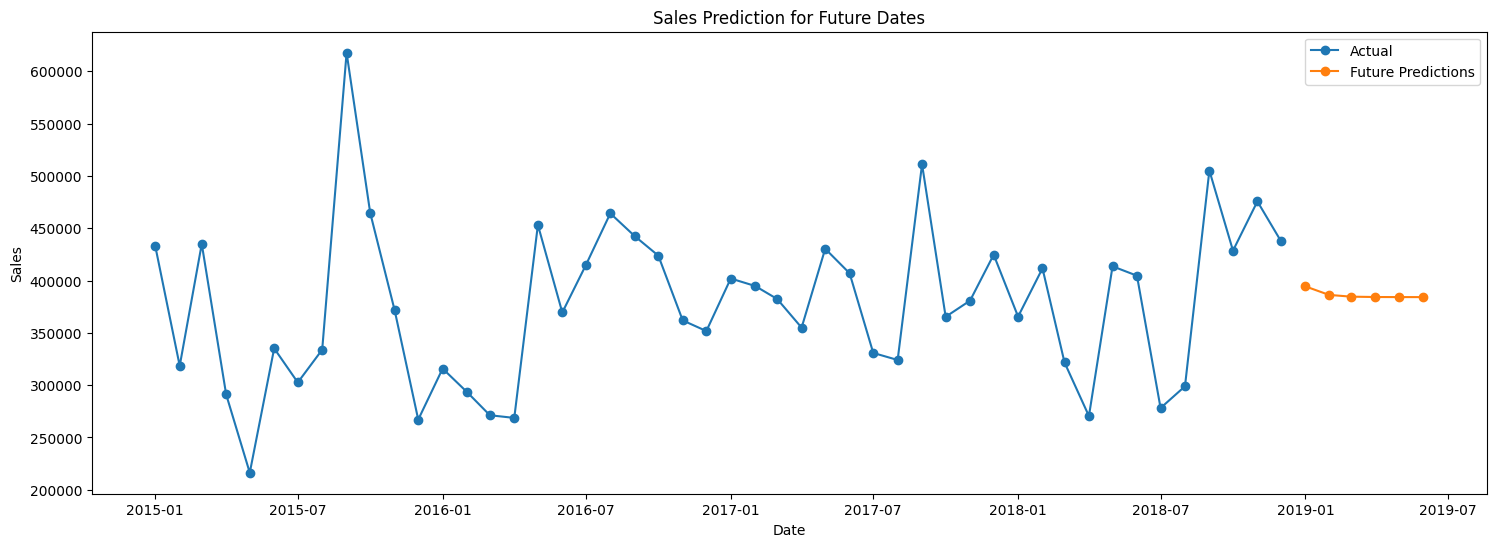

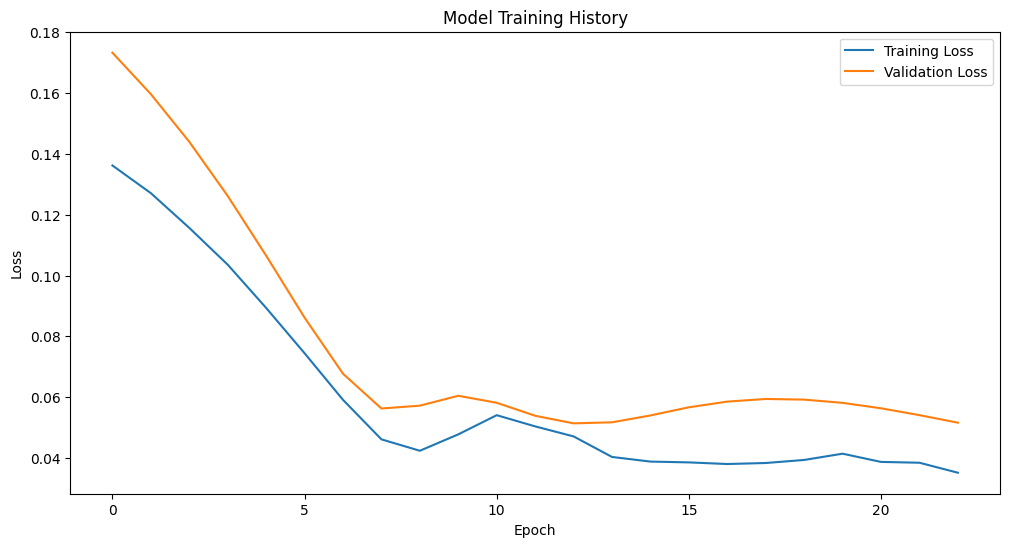

1/1 [==============================] - 0s 52ms/step - loss: 0.0690
Test Loss: 0.06898284703493118


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 363ms/step


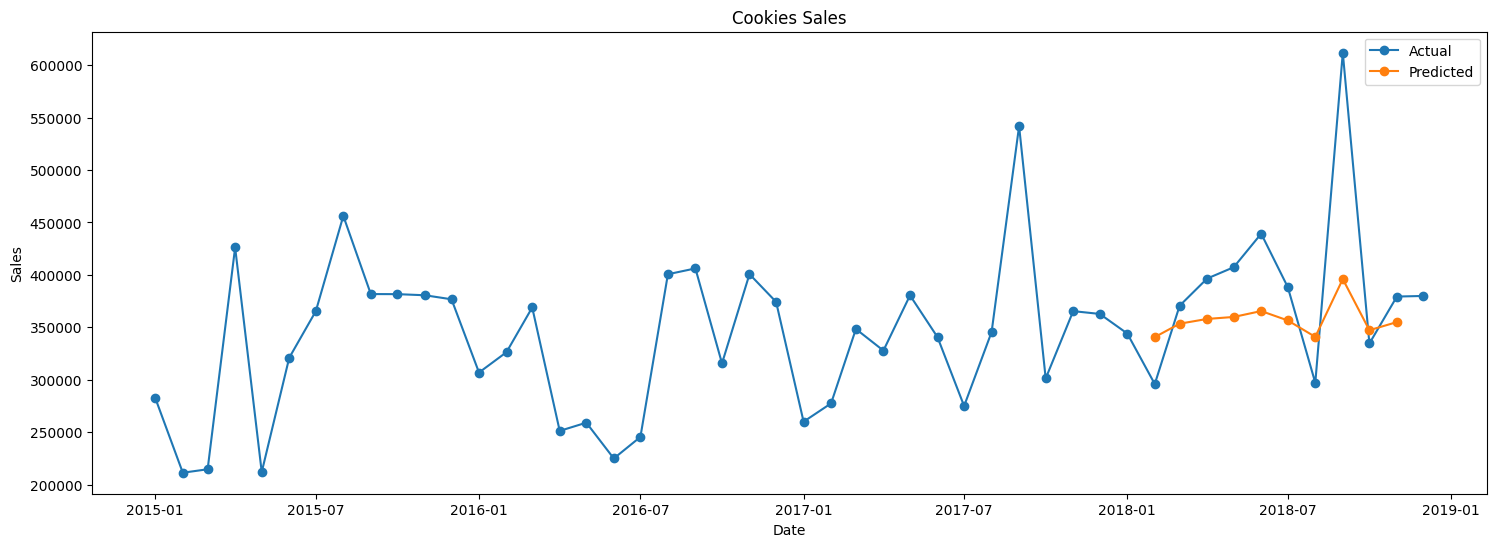

1/1 [==============================] - 0s 28ms/step


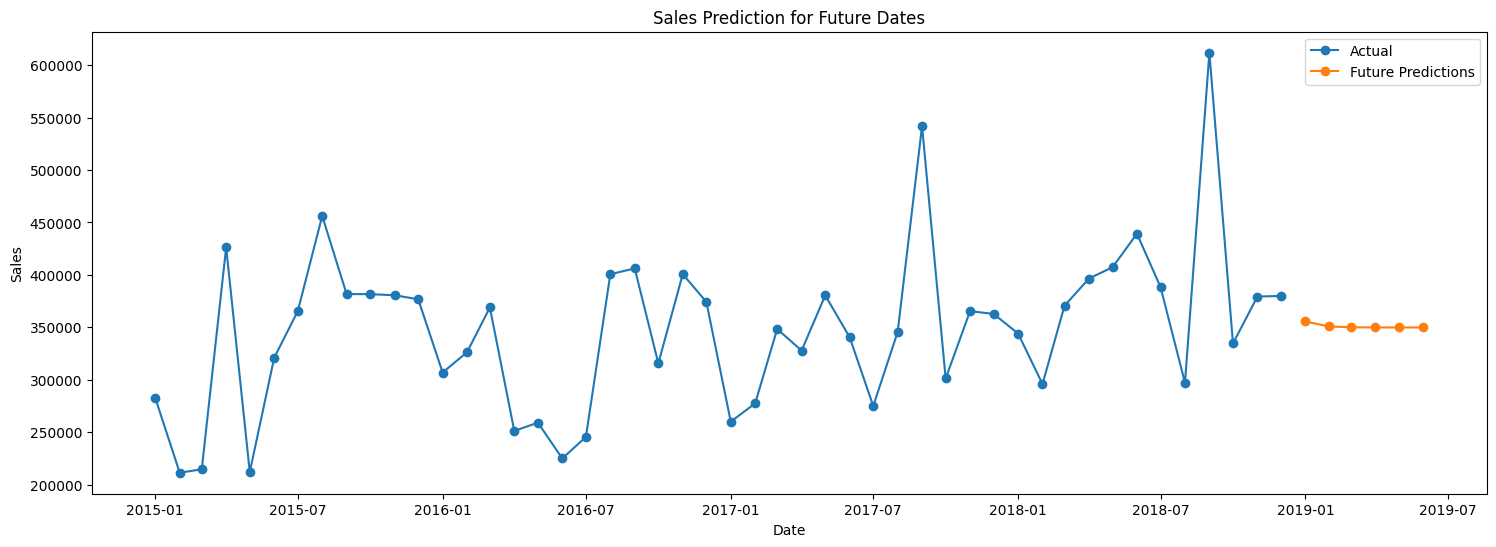

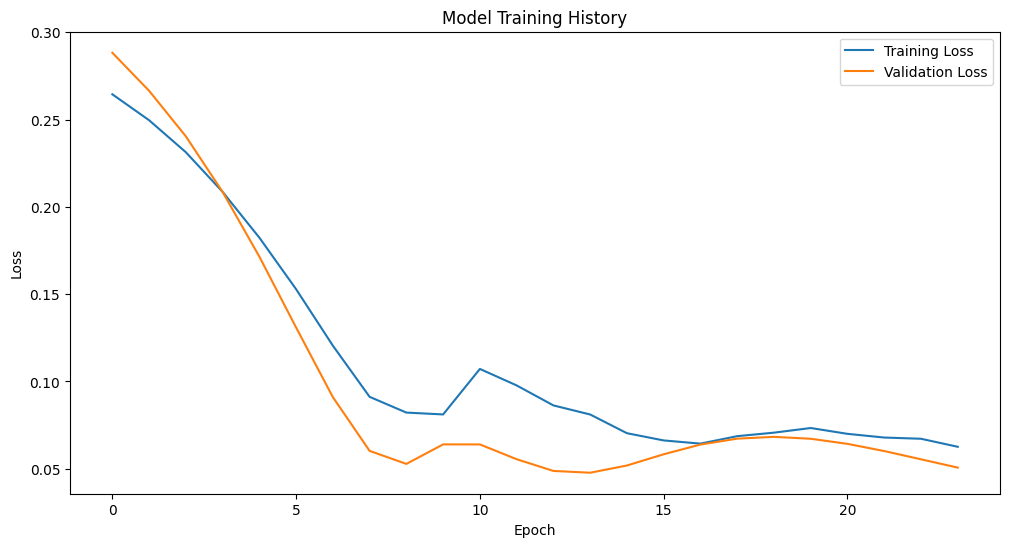

1/1 [==============================] - 0s 31ms/step - loss: 0.0376
Test Loss: 0.03763377666473389


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 246ms/step


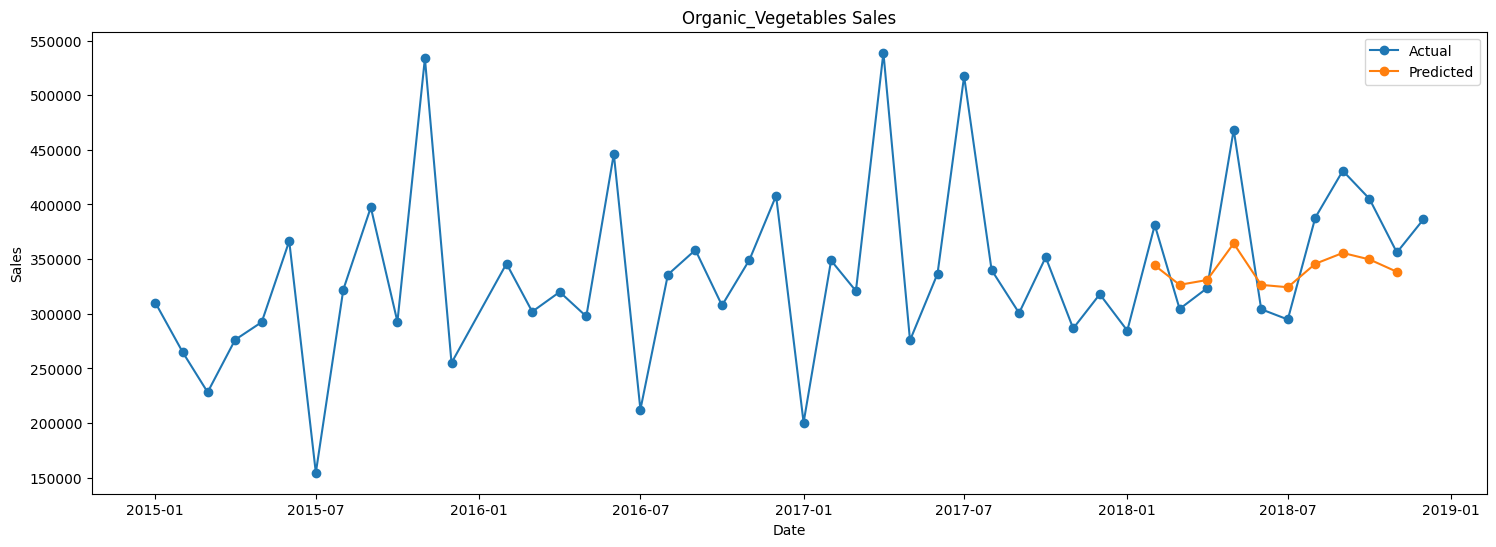

1/1 [==============================] - 0s 29ms/step


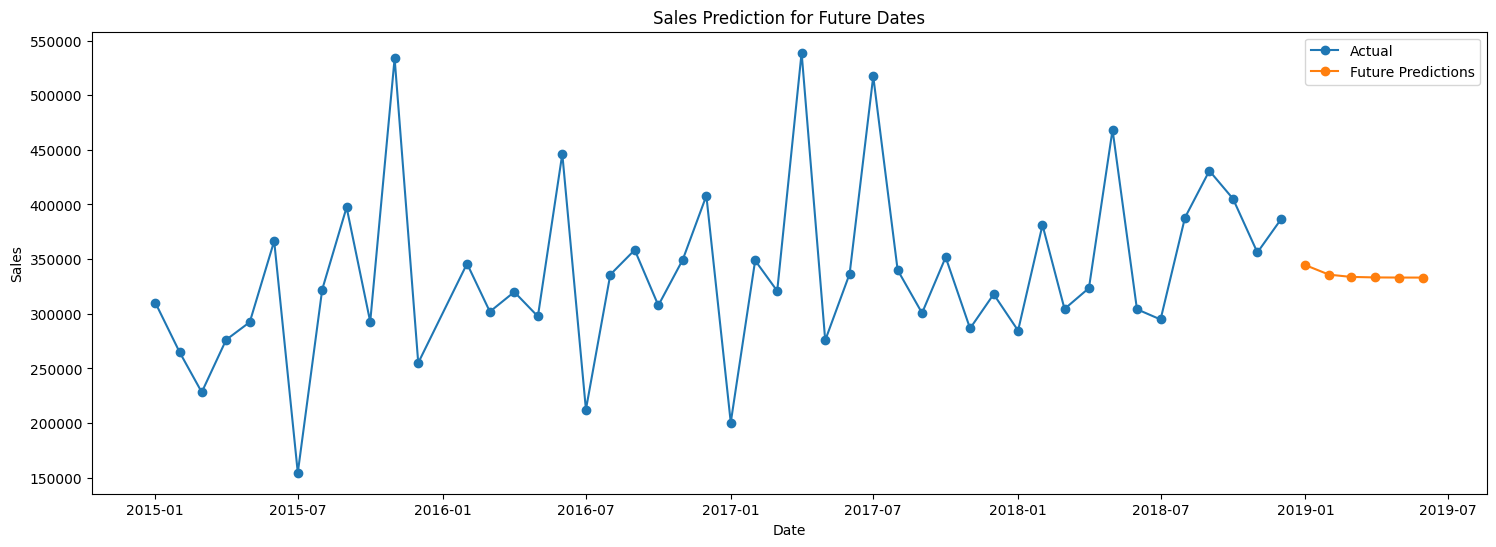

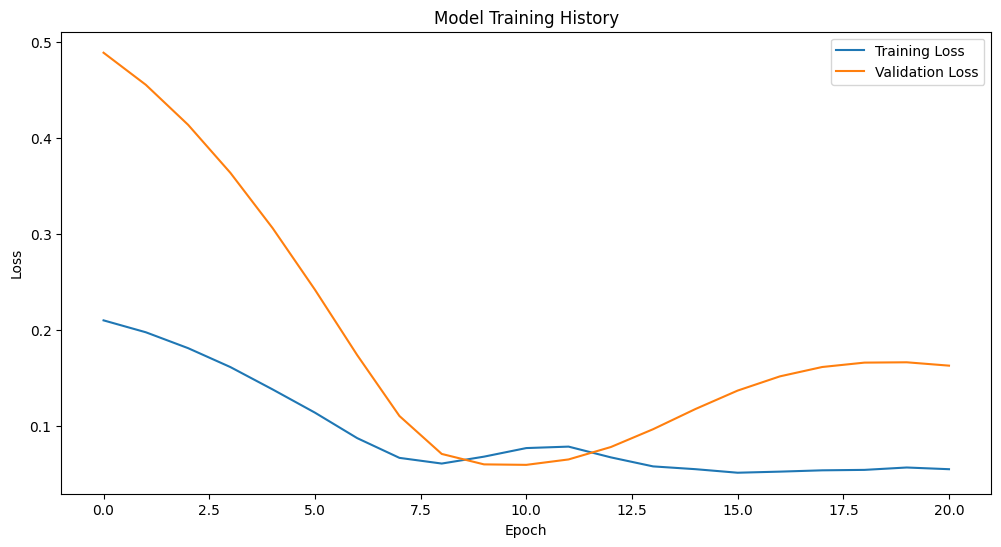

1/1 [==============================] - 0s 28ms/step - loss: 0.0386
Test Loss: 0.03859104961156845


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 248ms/step


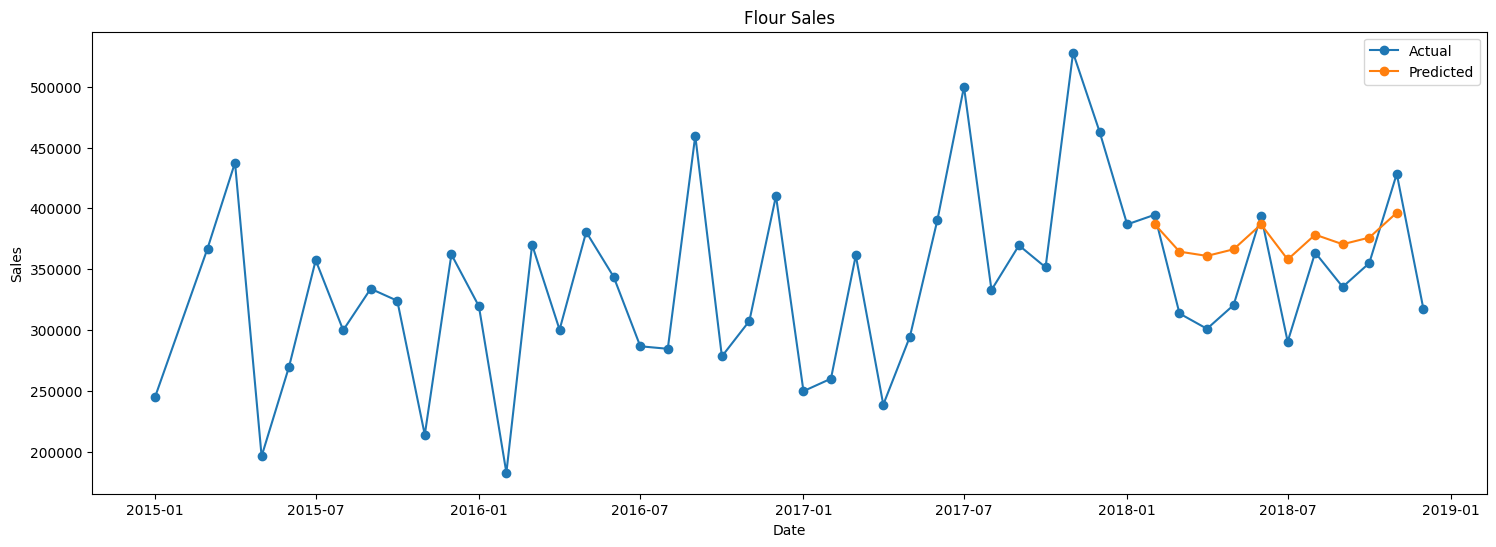

1/1 [==============================] - 0s 32ms/step


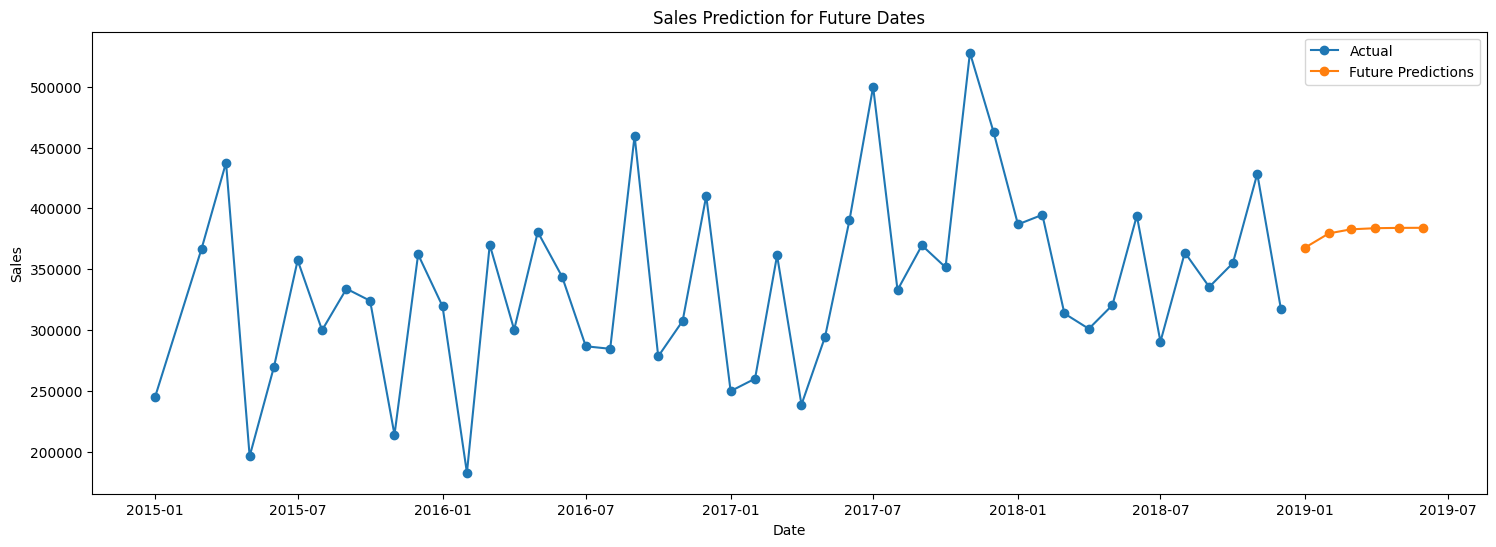

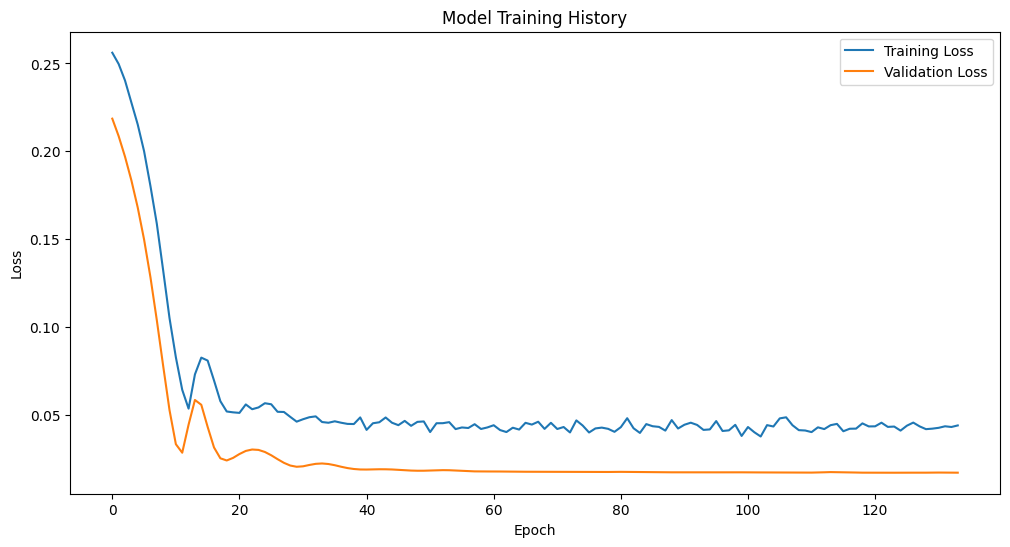

1/1 [==============================] - 0s 30ms/step - loss: 0.0162
Test Loss: 0.01621514931321144


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 248ms/step


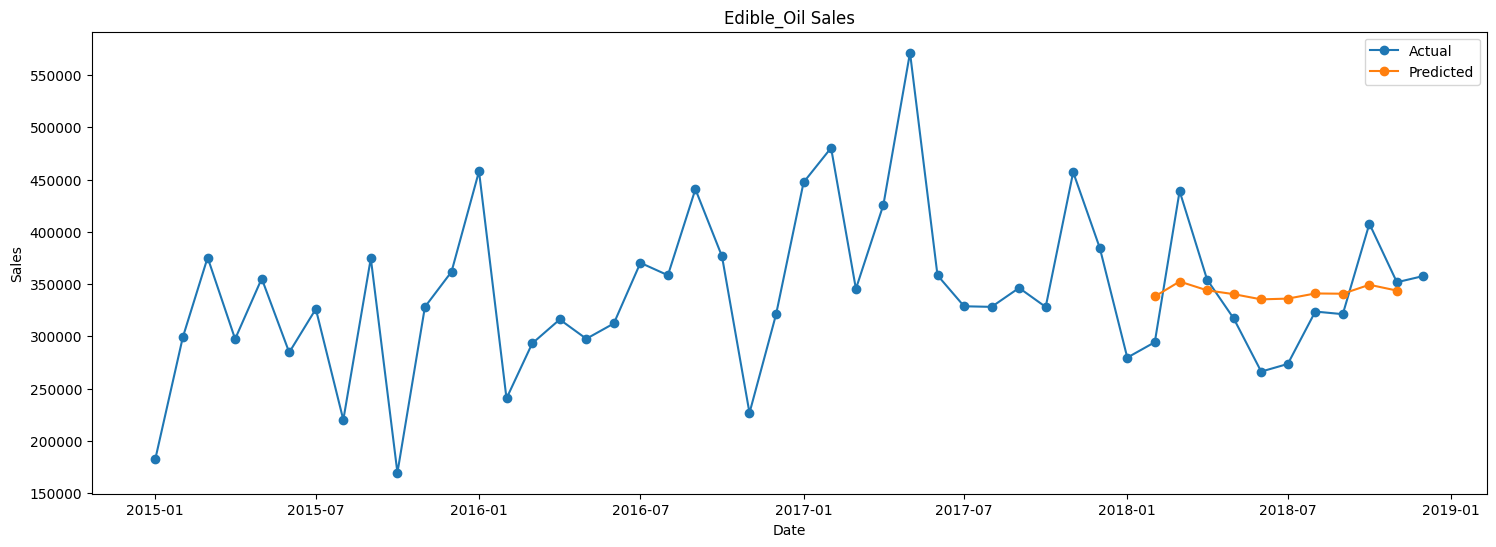

1/1 [==============================] - 0s 31ms/step


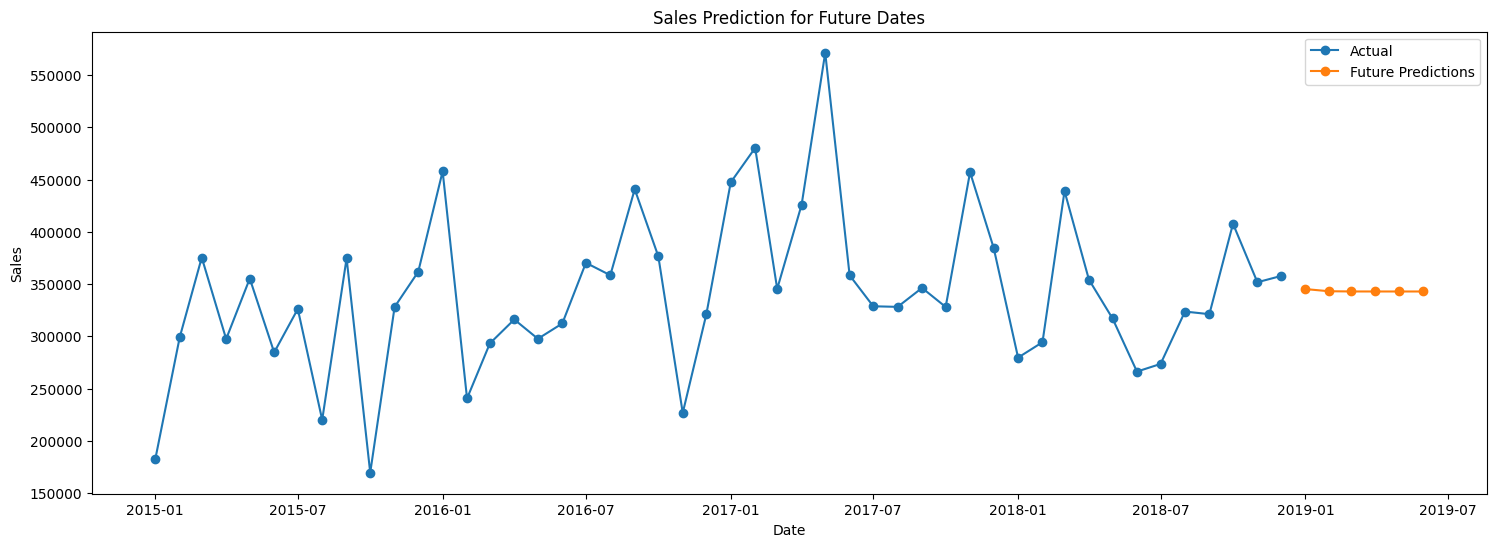

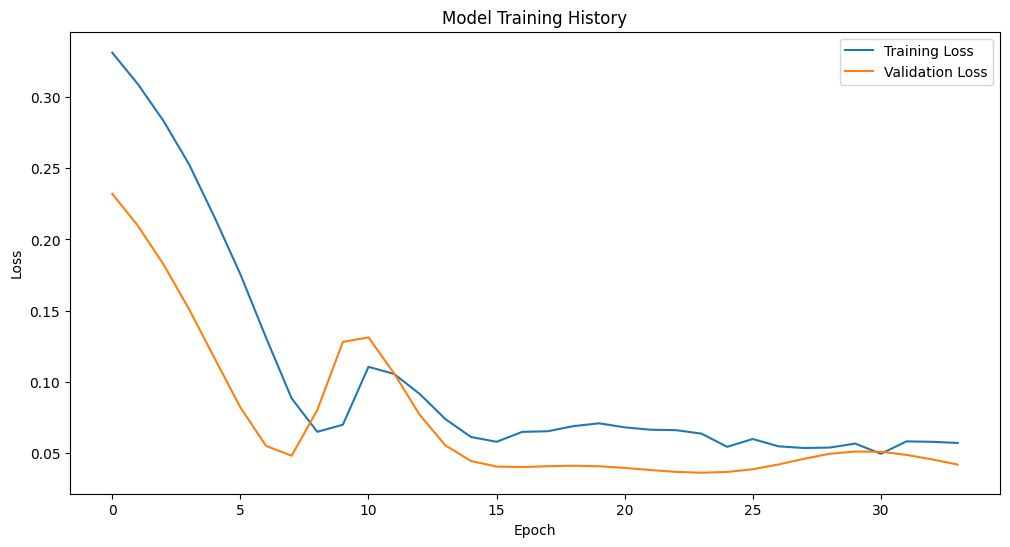

1/1 [==============================] - 0s 26ms/step - loss: 0.0174
Test Loss: 0.017411332577466965


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 246ms/step


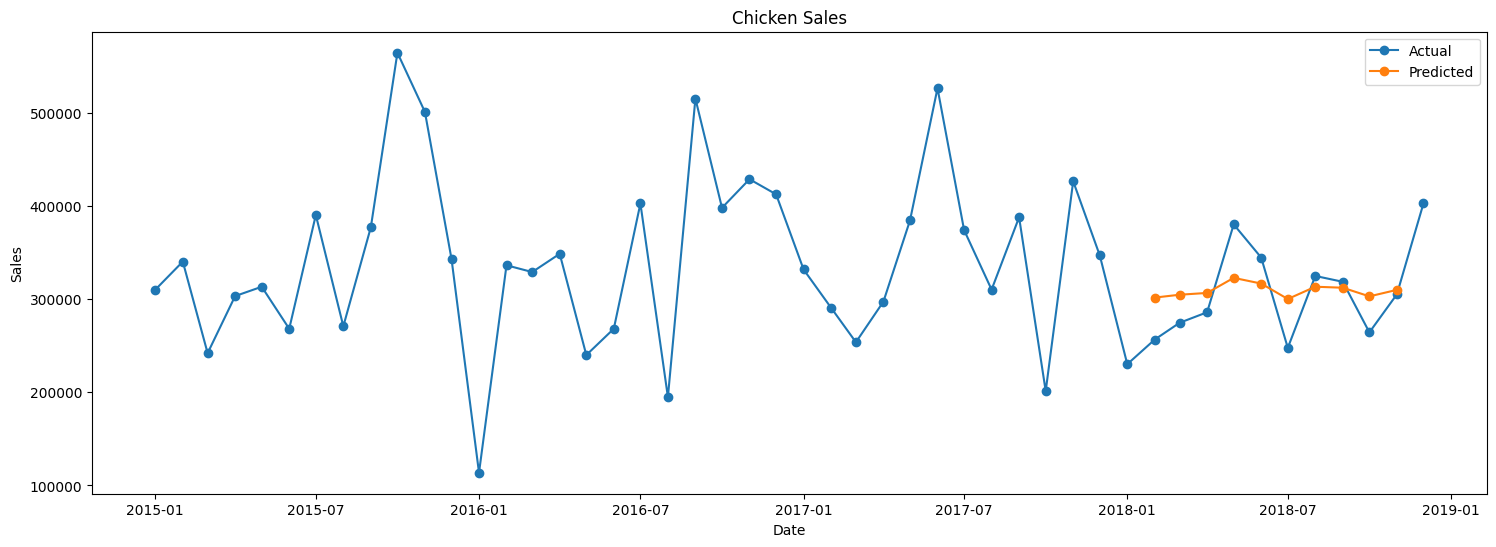

1/1 [==============================] - 0s 31ms/step


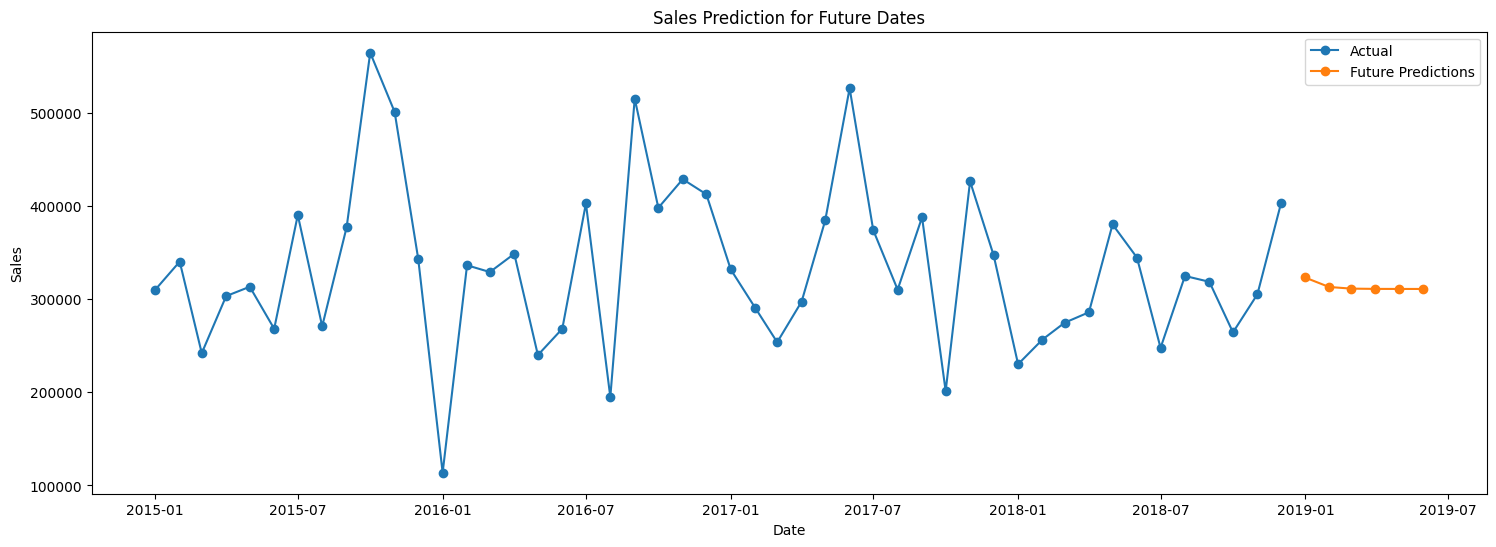

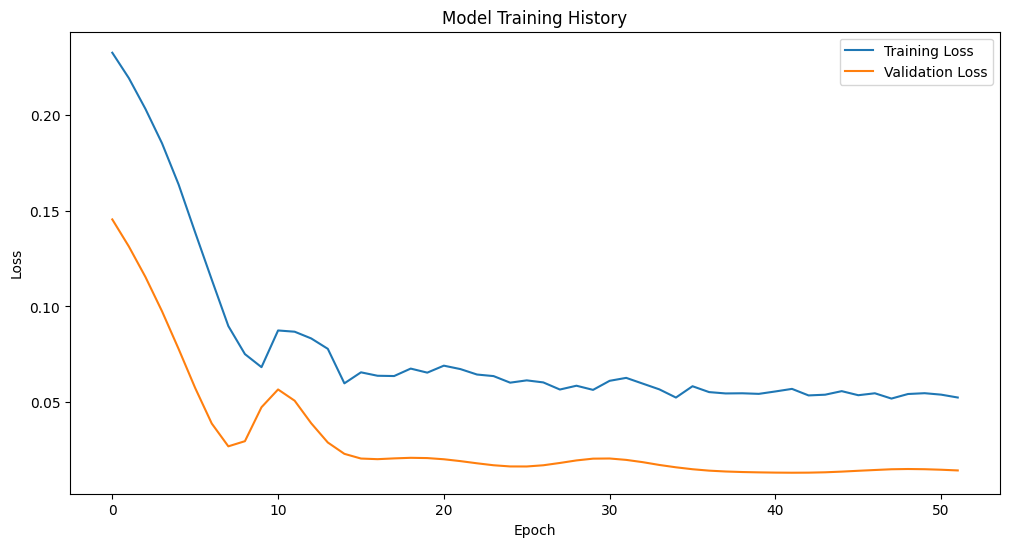

1/1 [==============================] - 0s 40ms/step - loss: 0.0206
Test Loss: 0.020580420270562172


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 250ms/step


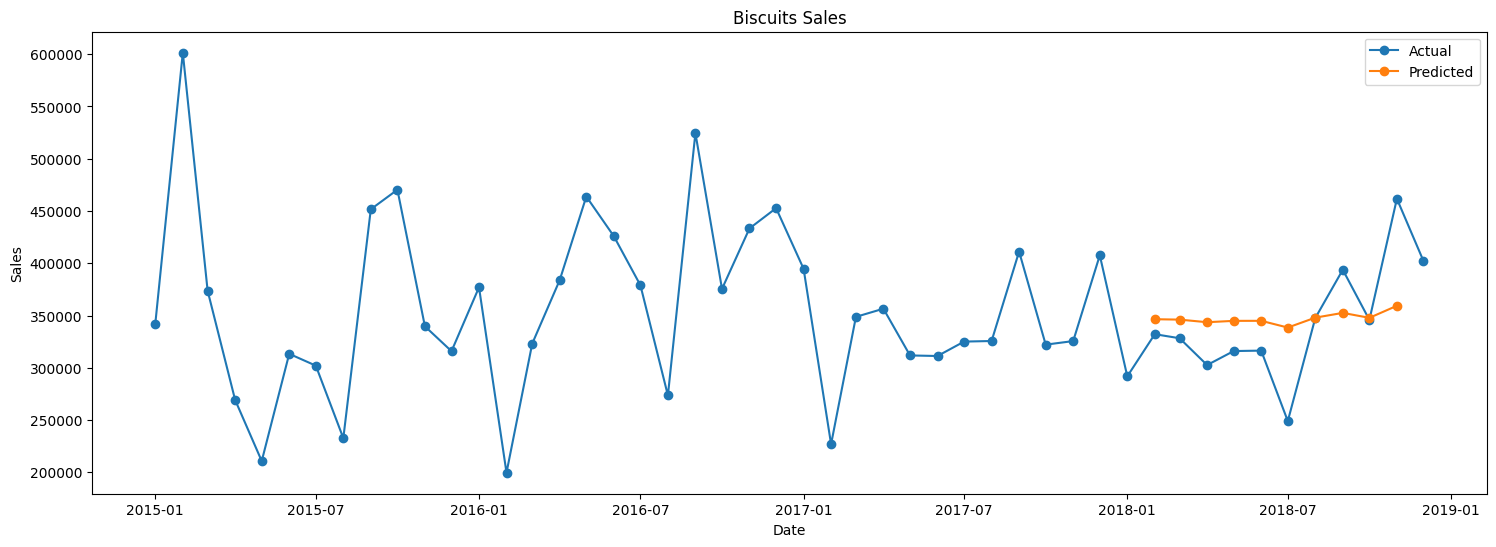

1/1 [==============================] - 0s 32ms/step


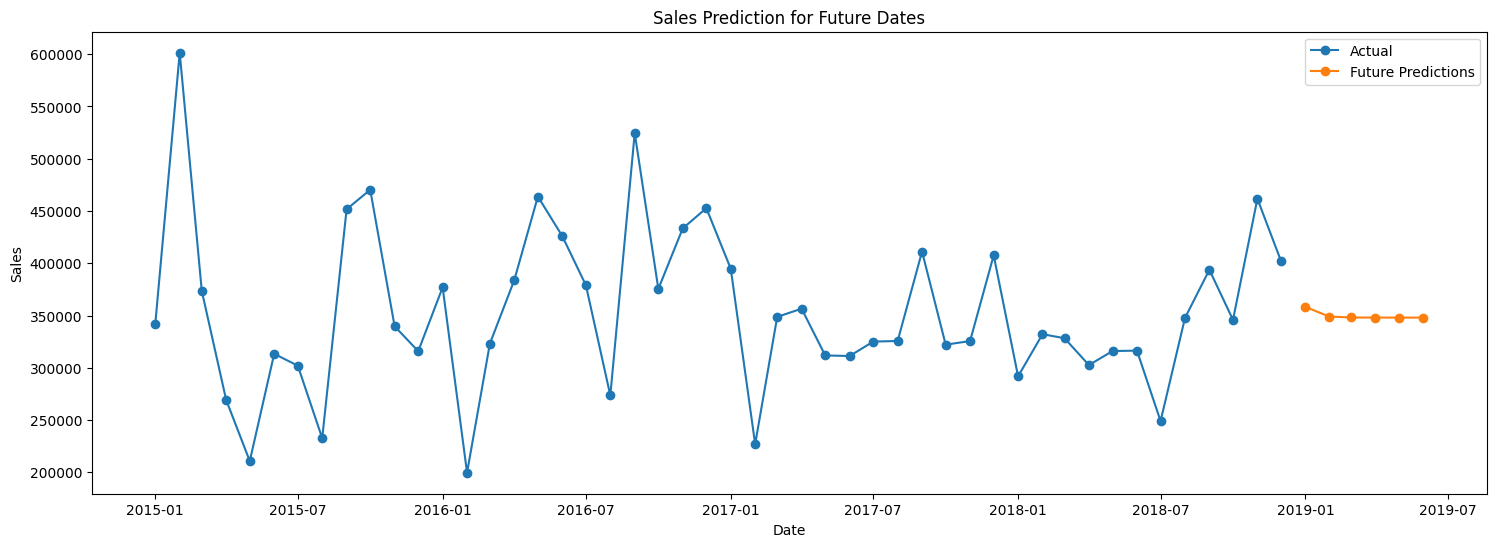

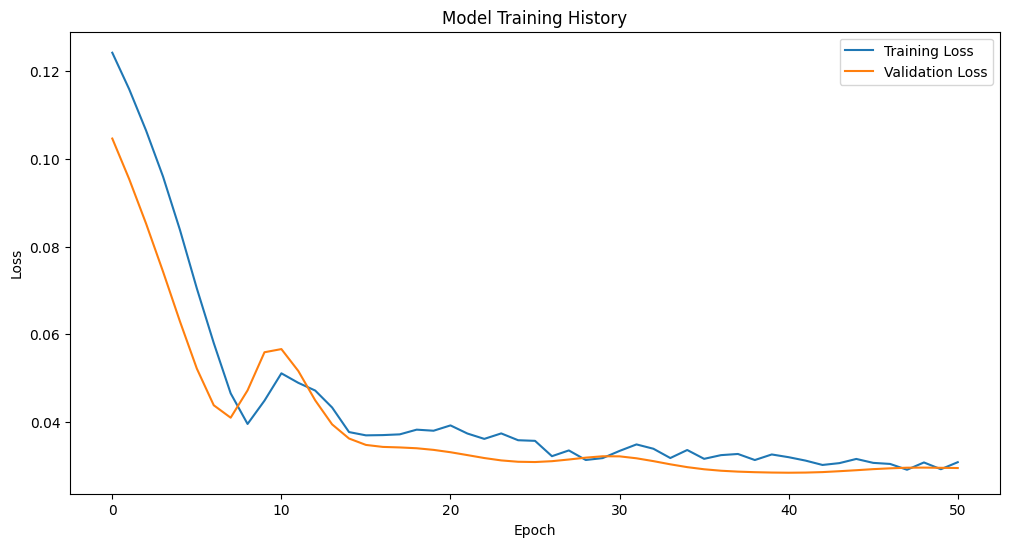

1/1 [==============================] - 0s 30ms/step - loss: 0.0271
Test Loss: 0.027088958770036697


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 253ms/step


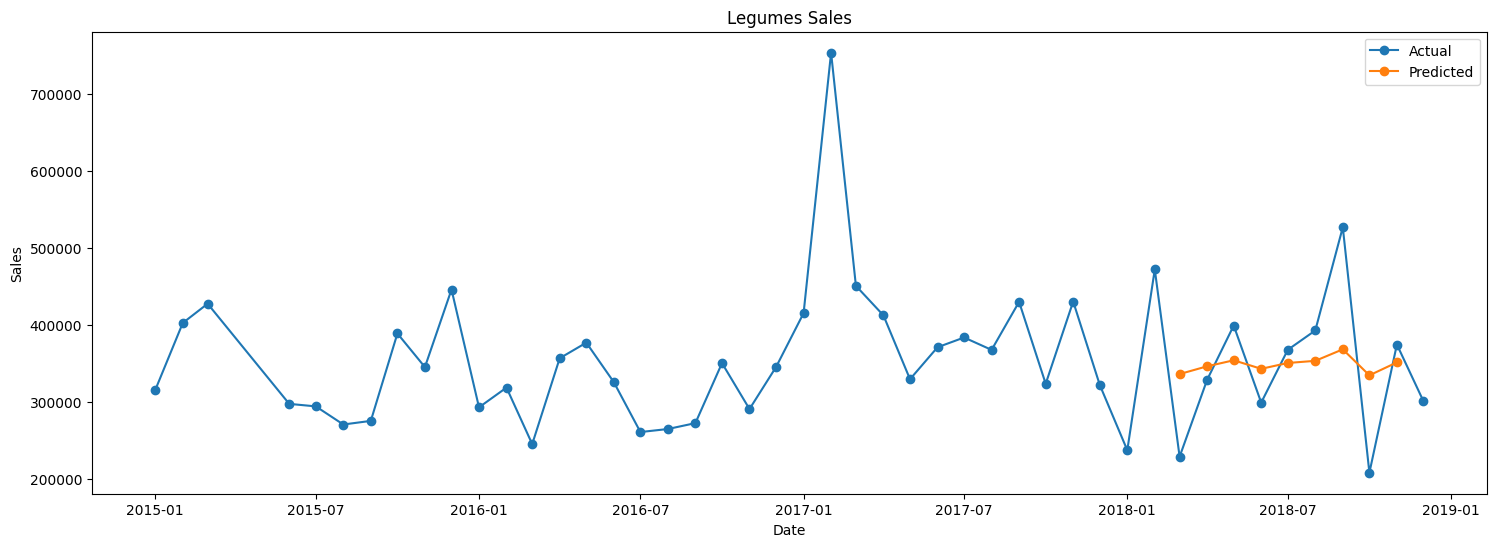

1/1 [==============================] - 0s 34ms/step


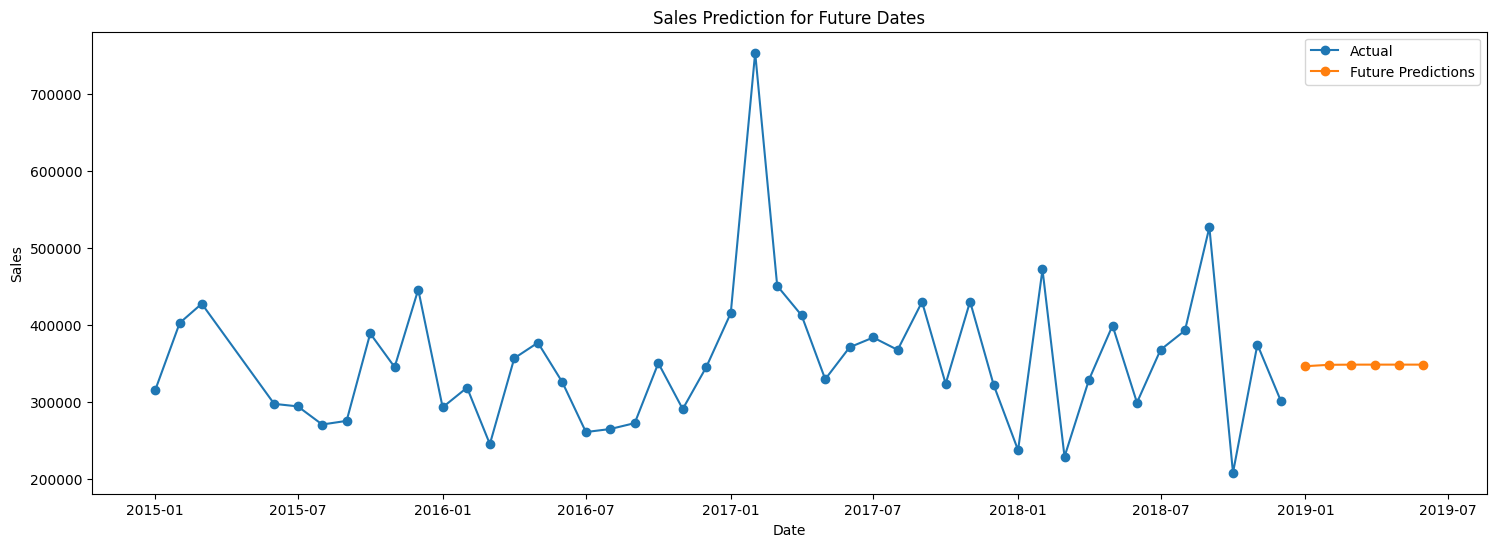

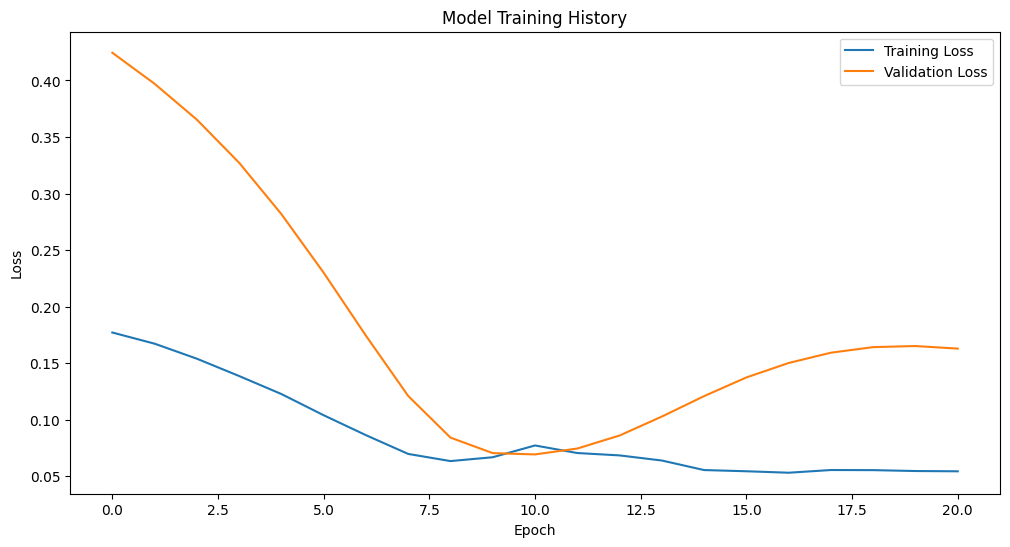

1/1 [==============================] - 0s 34ms/step - loss: 0.0614
Test Loss: 0.06135444715619087


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 398ms/step


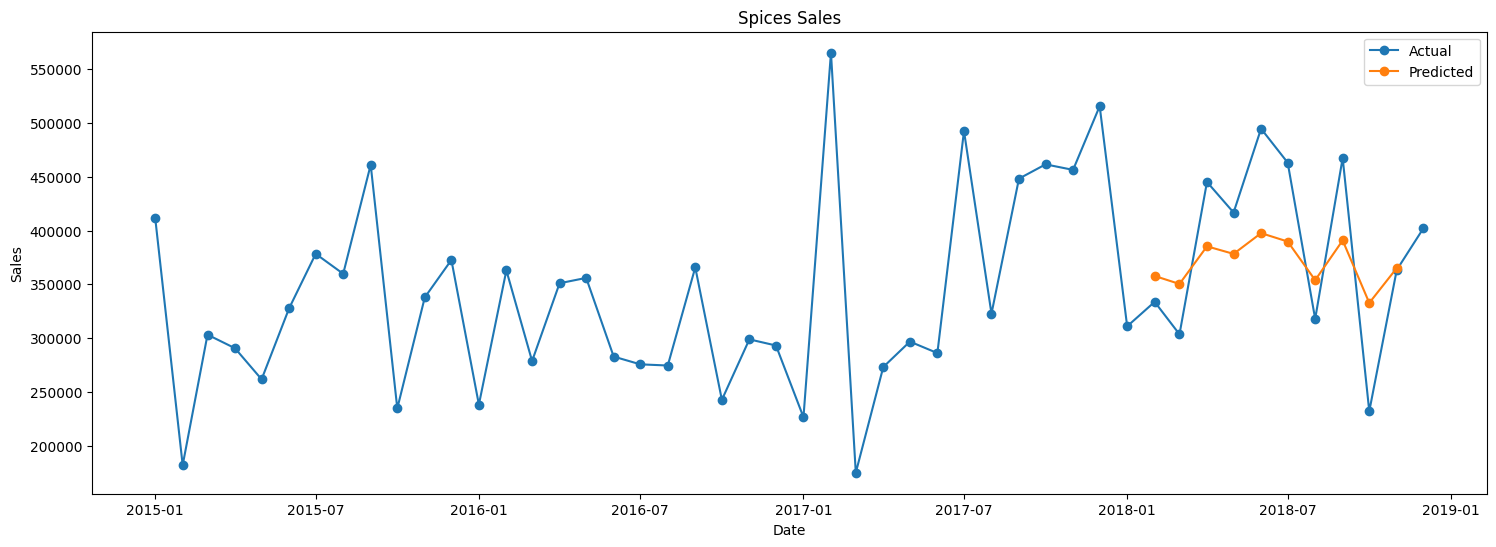

1/1 [==============================] - 0s 49ms/step


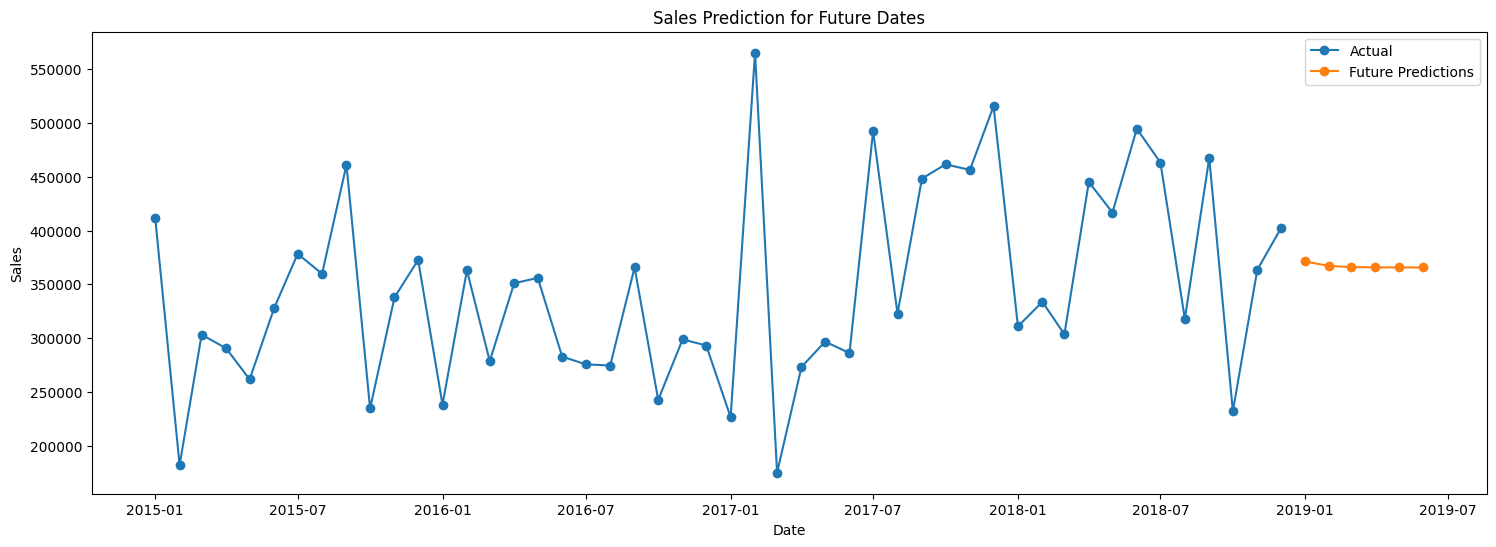

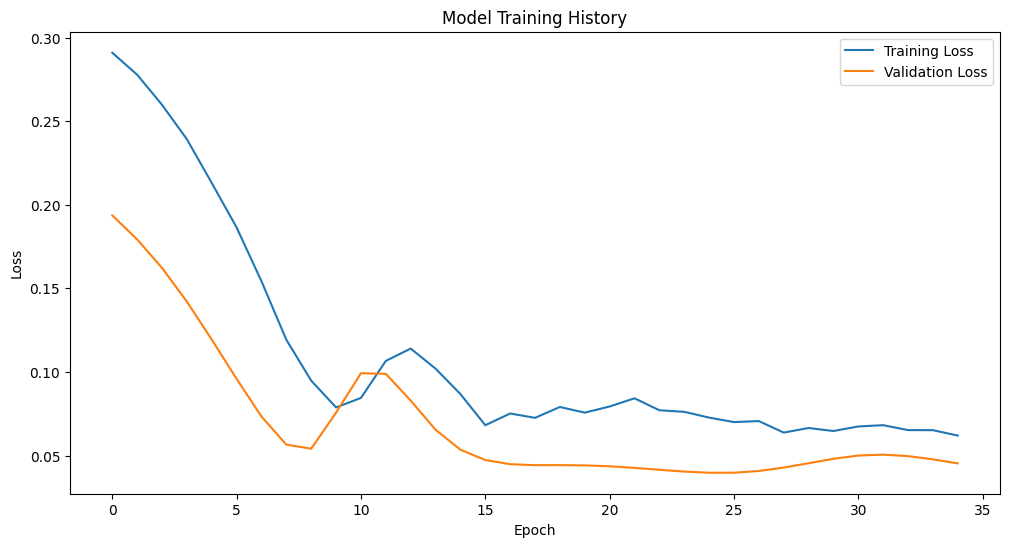

1/1 [==============================] - 0s 33ms/step - loss: 0.0545
Test Loss: 0.05450909584760666


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 255ms/step


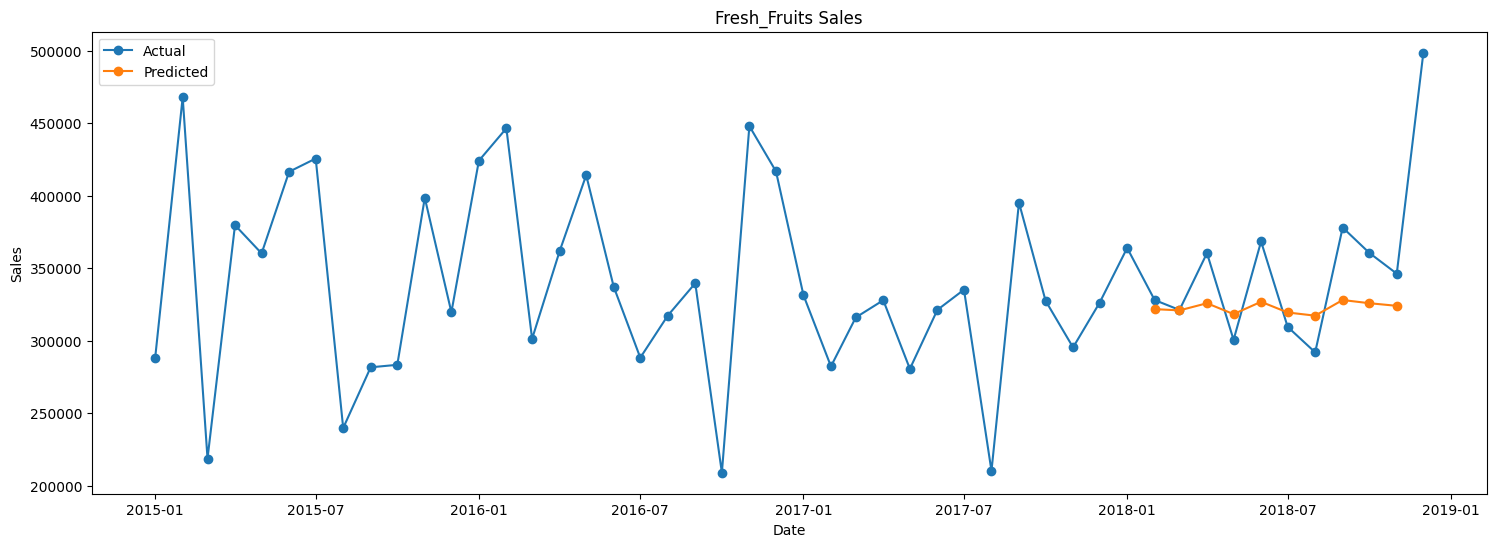

1/1 [==============================] - 0s 33ms/step


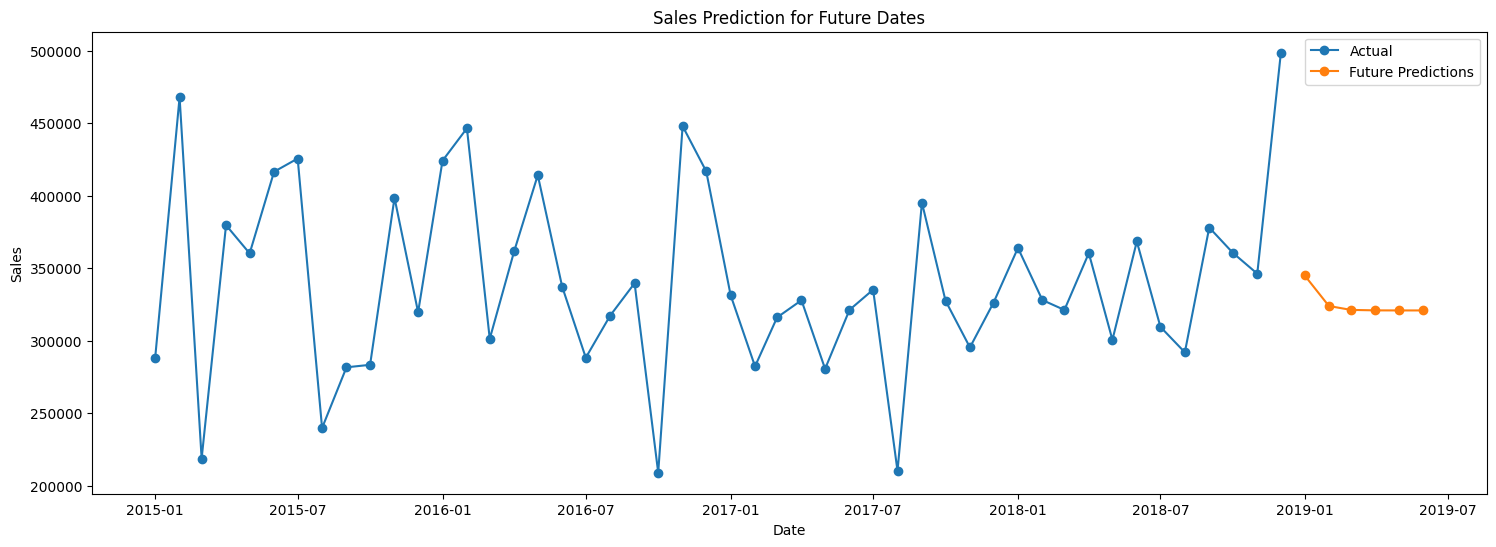

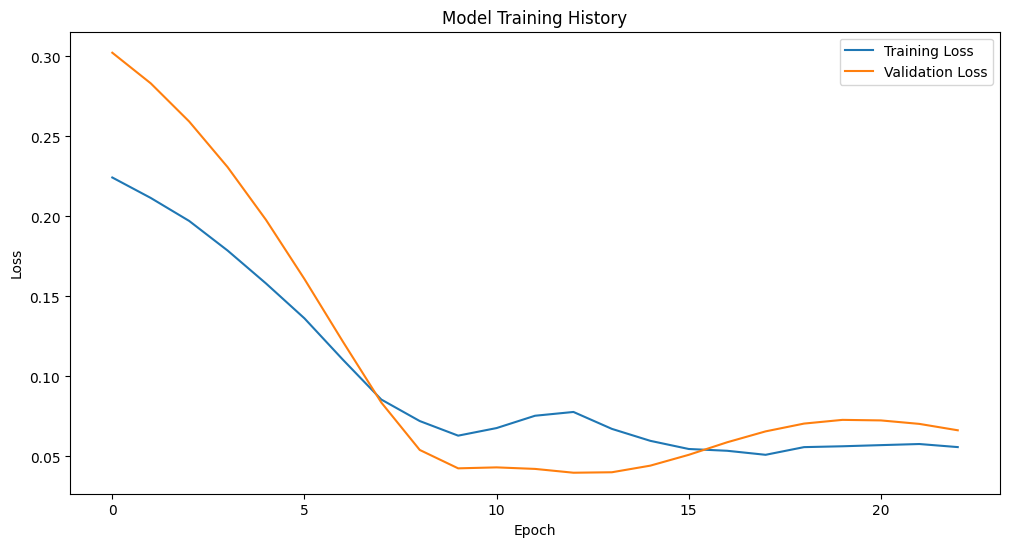

1/1 [==============================] - 0s 58ms/step - loss: 0.0265
Test Loss: 0.026468198746442795


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 380ms/step


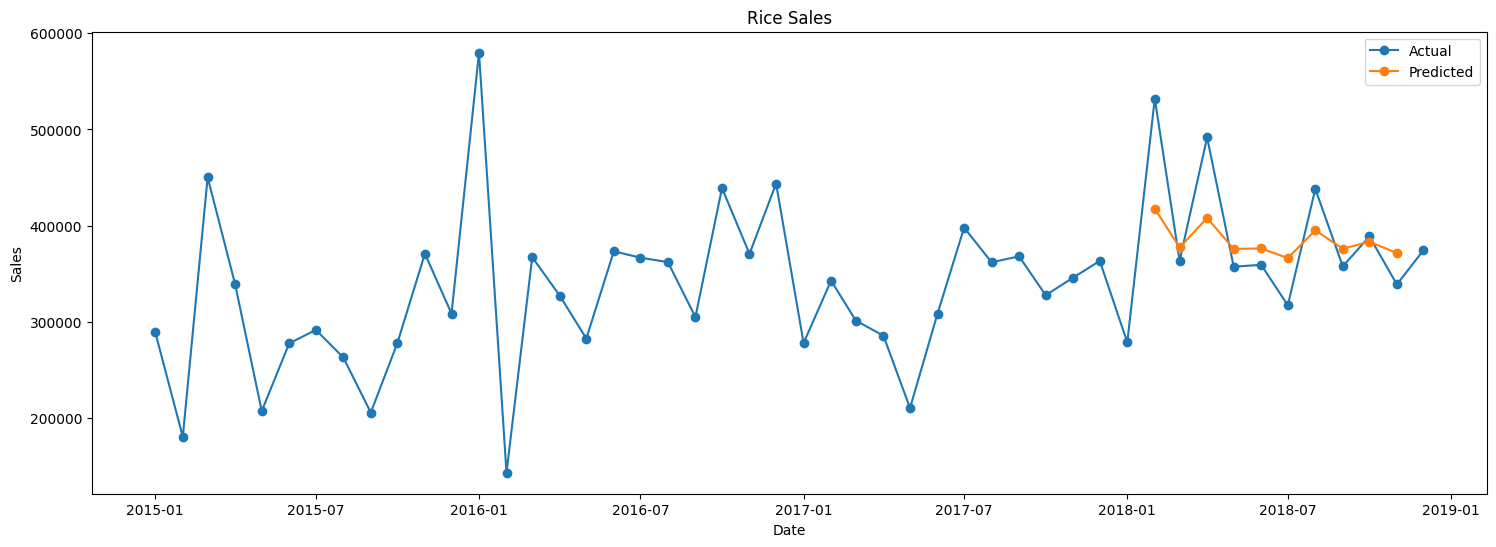

1/1 [==============================] - 0s 33ms/step


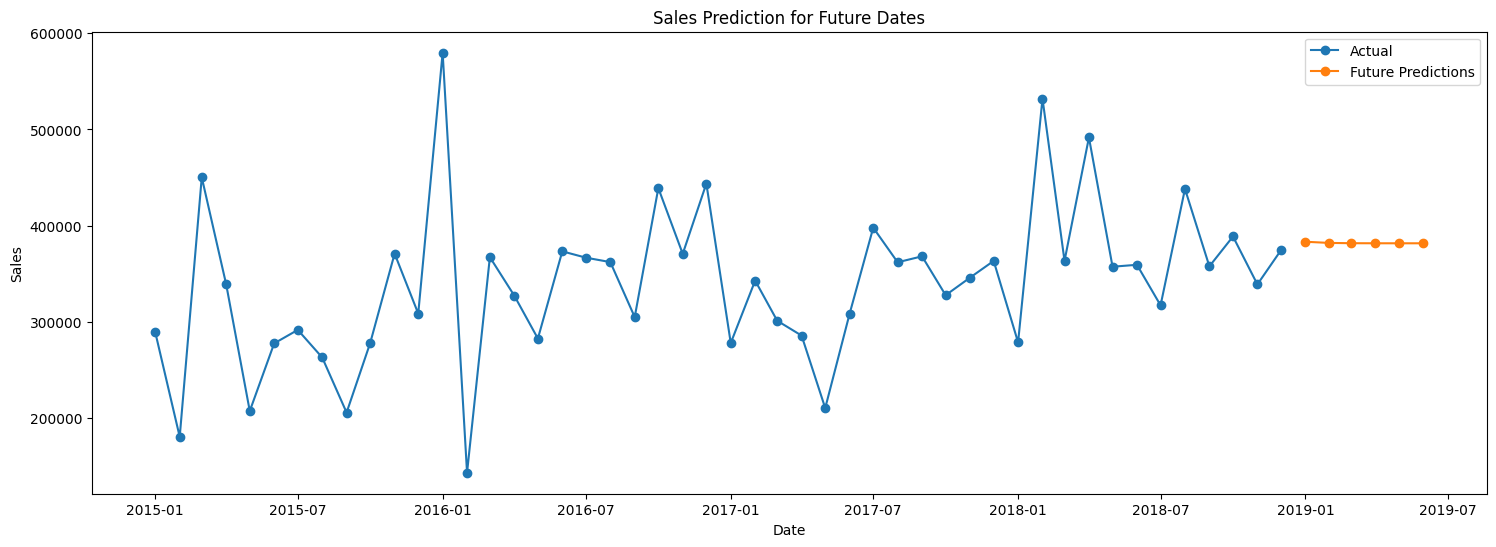

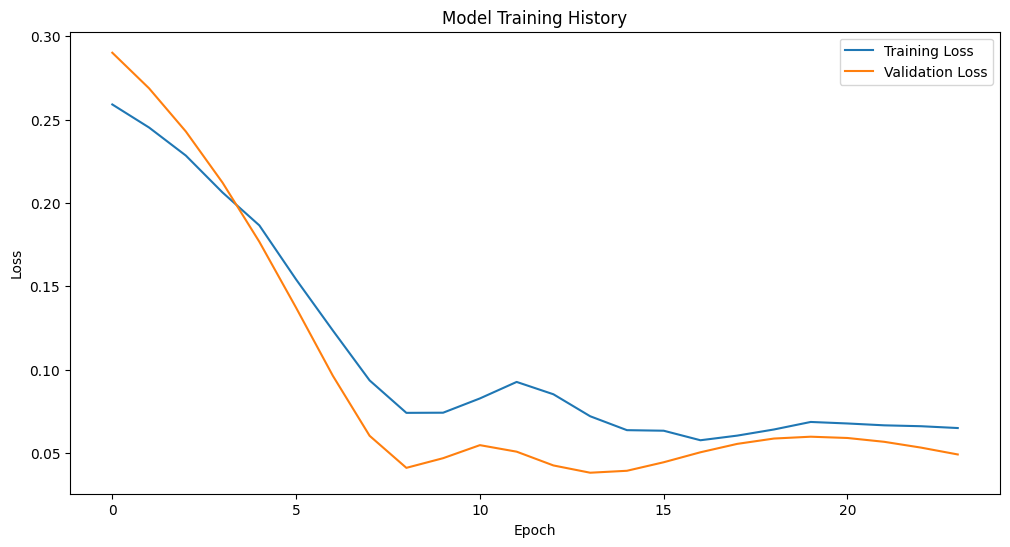

1/1 [==============================] - 0s 34ms/step - loss: 0.0227
Test Loss: 0.022671116515994072


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 252ms/step


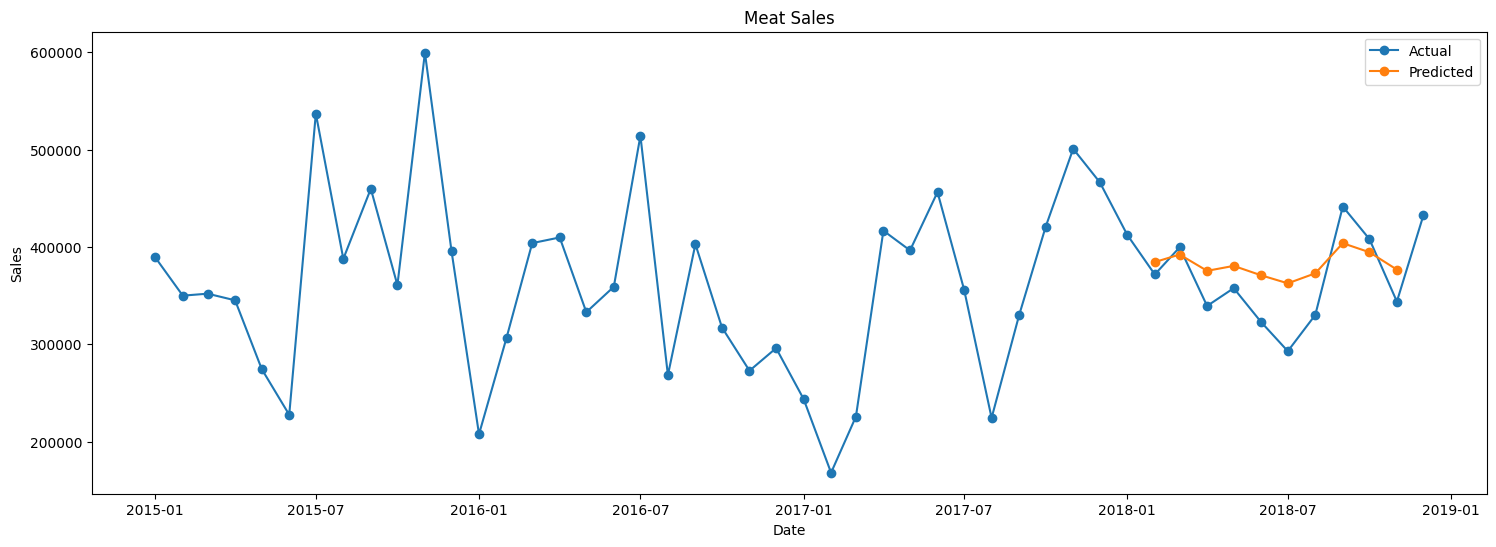

1/1 [==============================] - 0s 34ms/step


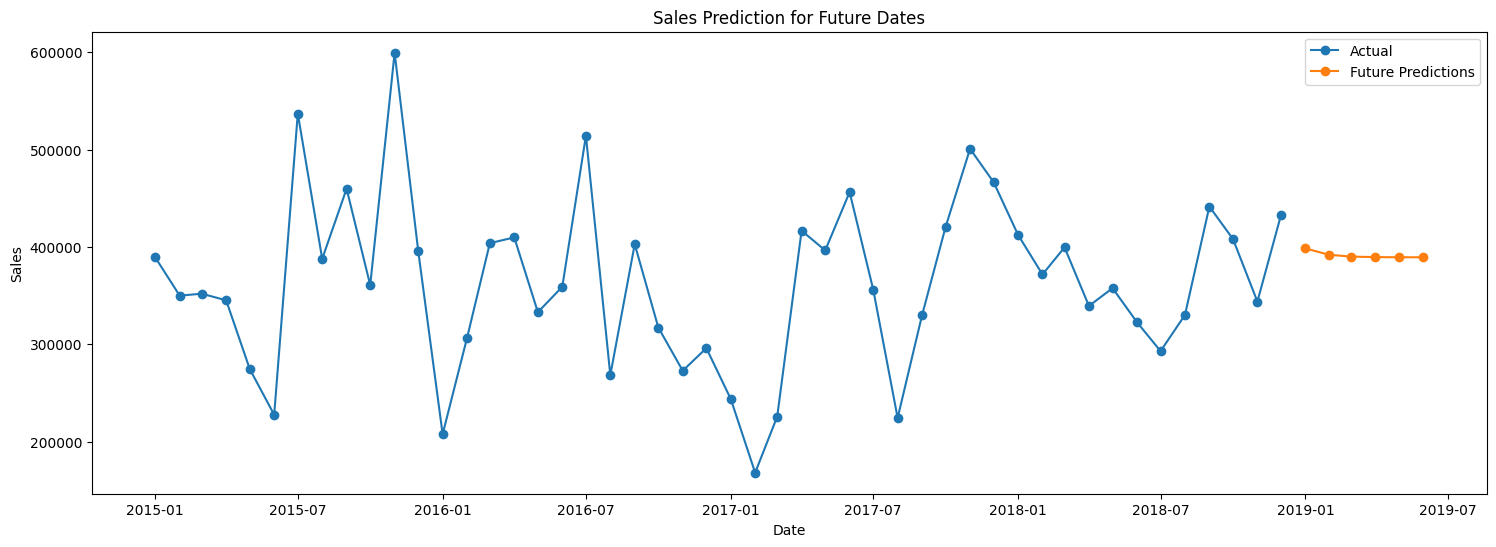

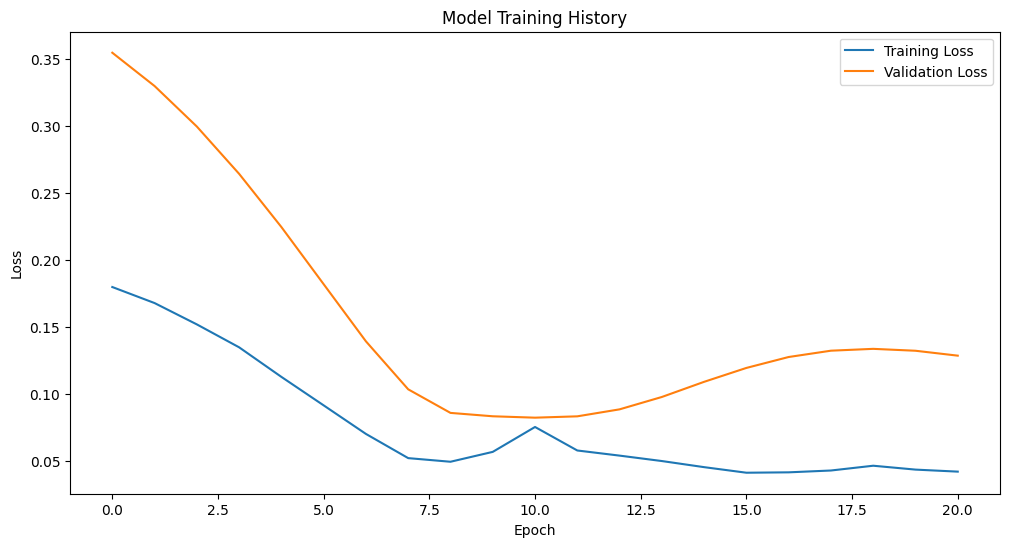

1/1 [==============================] - 0s 42ms/step - loss: 0.0489
Test Loss: 0.048904068768024445


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 335ms/step


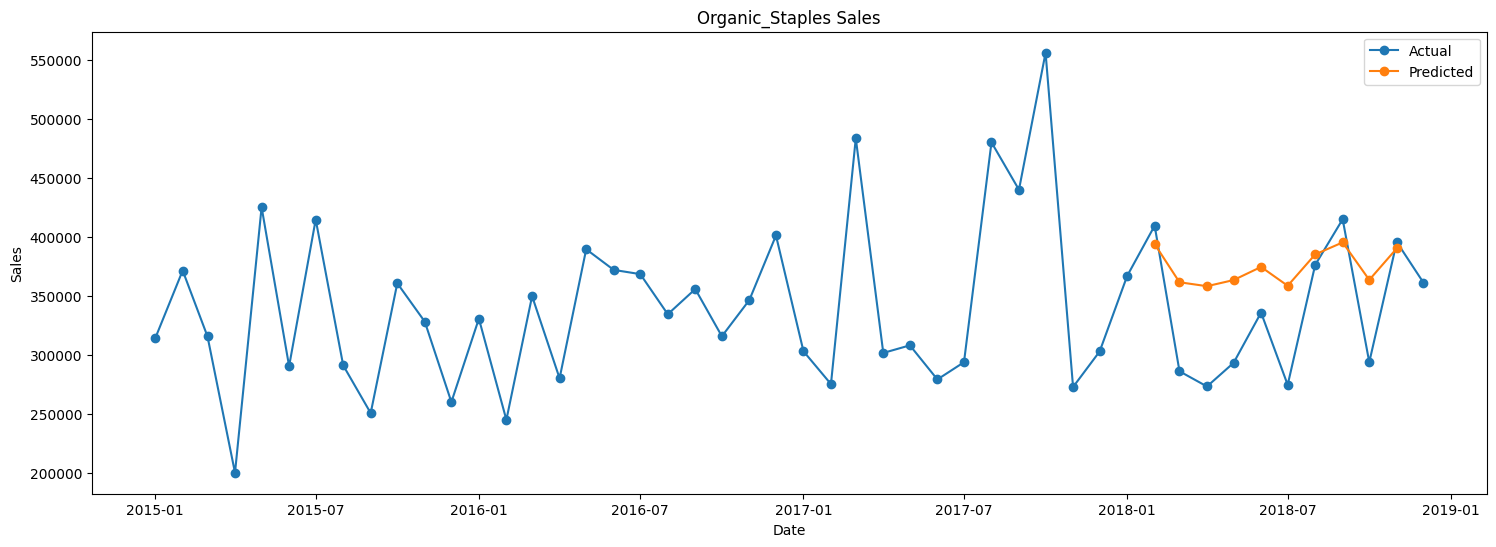

1/1 [==============================] - 0s 45ms/step


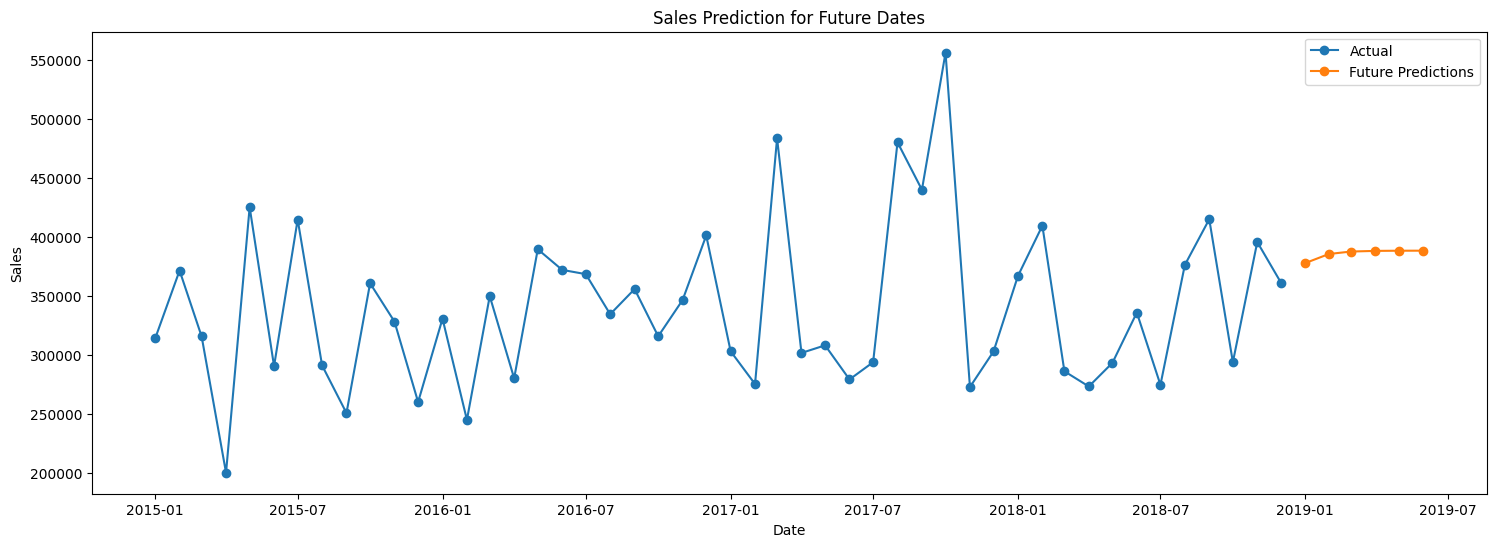

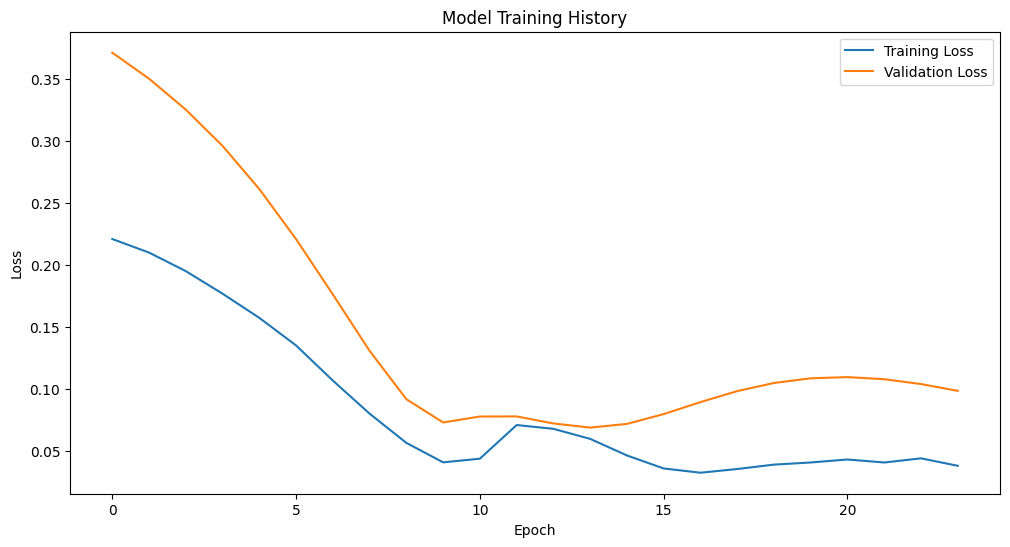

1/1 [==============================] - 0s 40ms/step - loss: 0.0422
Test Loss: 0.04219038784503937


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 280ms/step


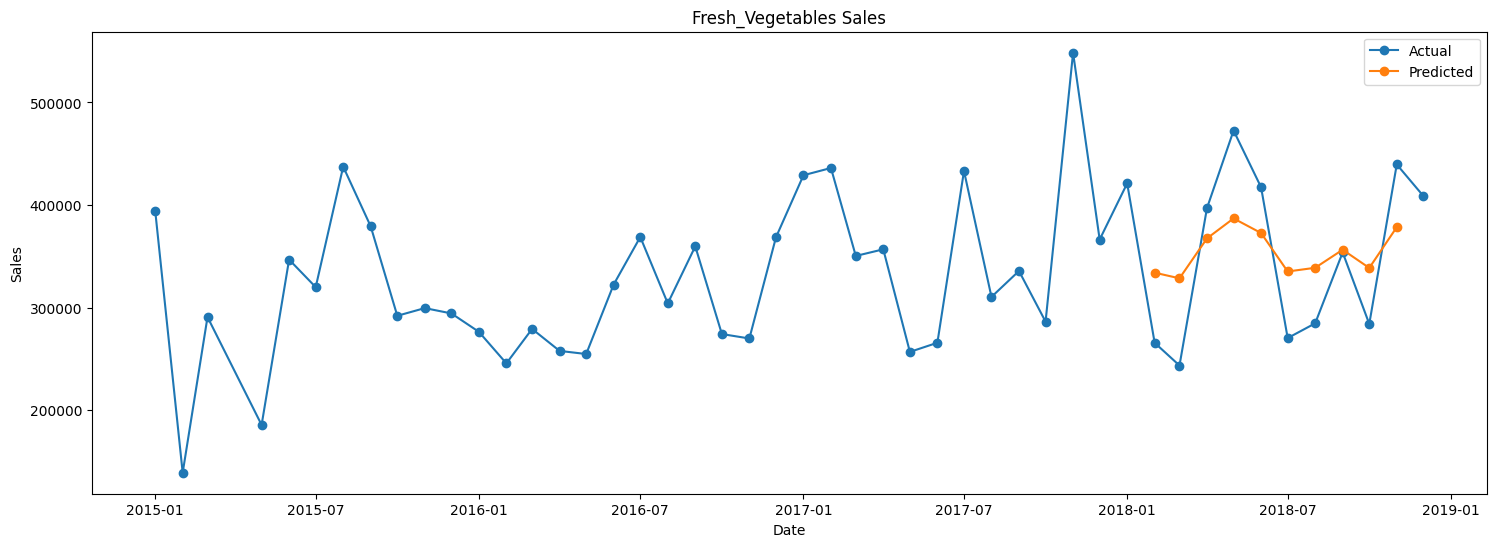

1/1 [==============================] - 0s 40ms/step


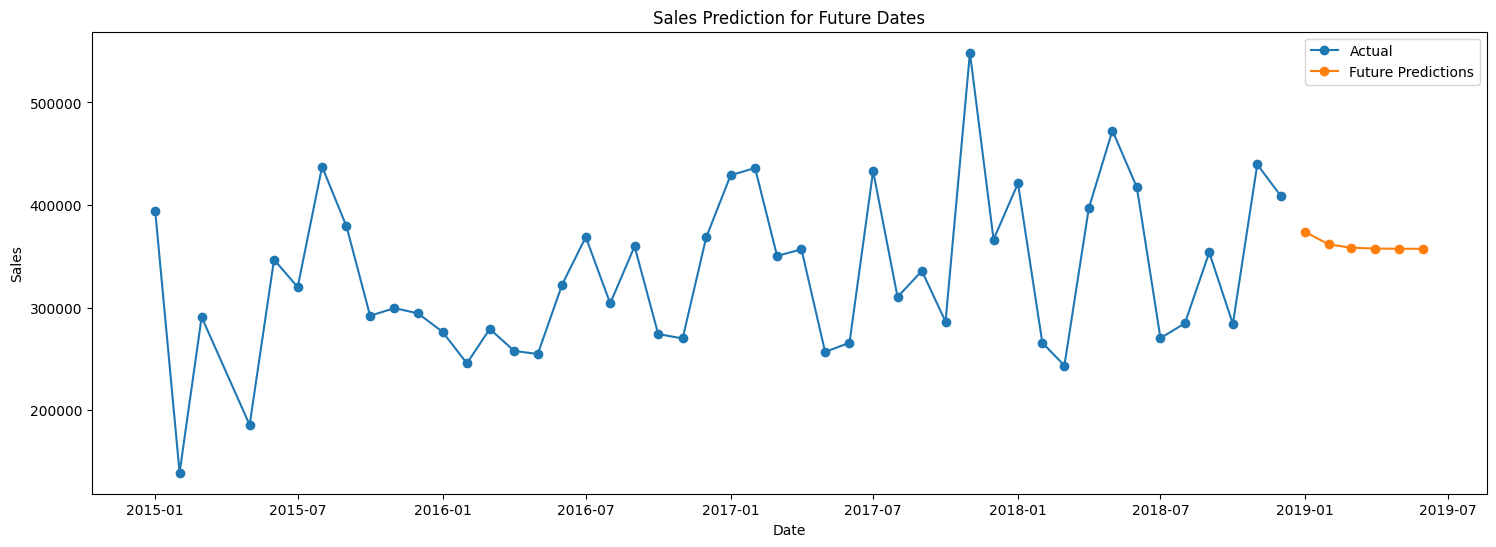

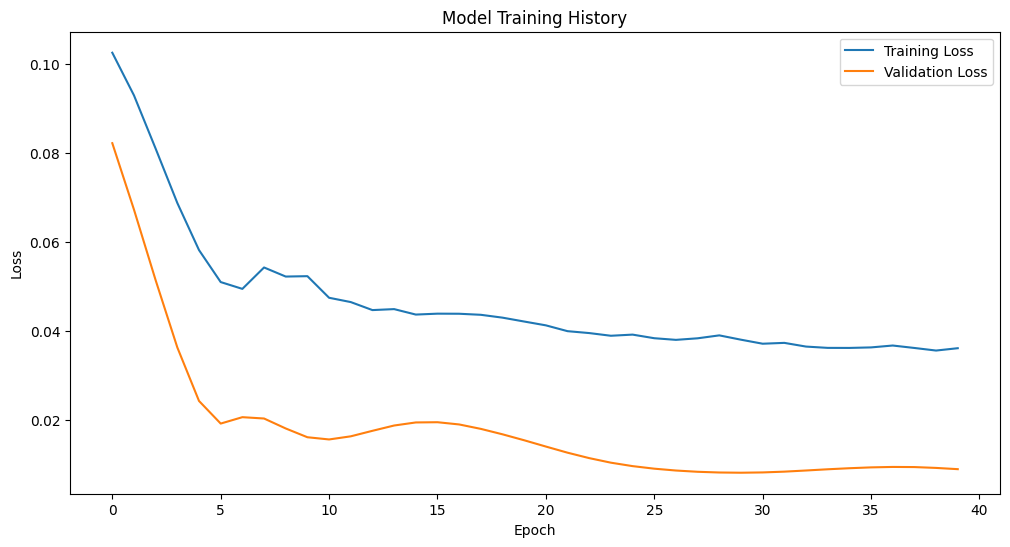

1/1 [==============================] - 0s 44ms/step - loss: 0.0089
Test Loss: 0.008877309039235115


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 298ms/step


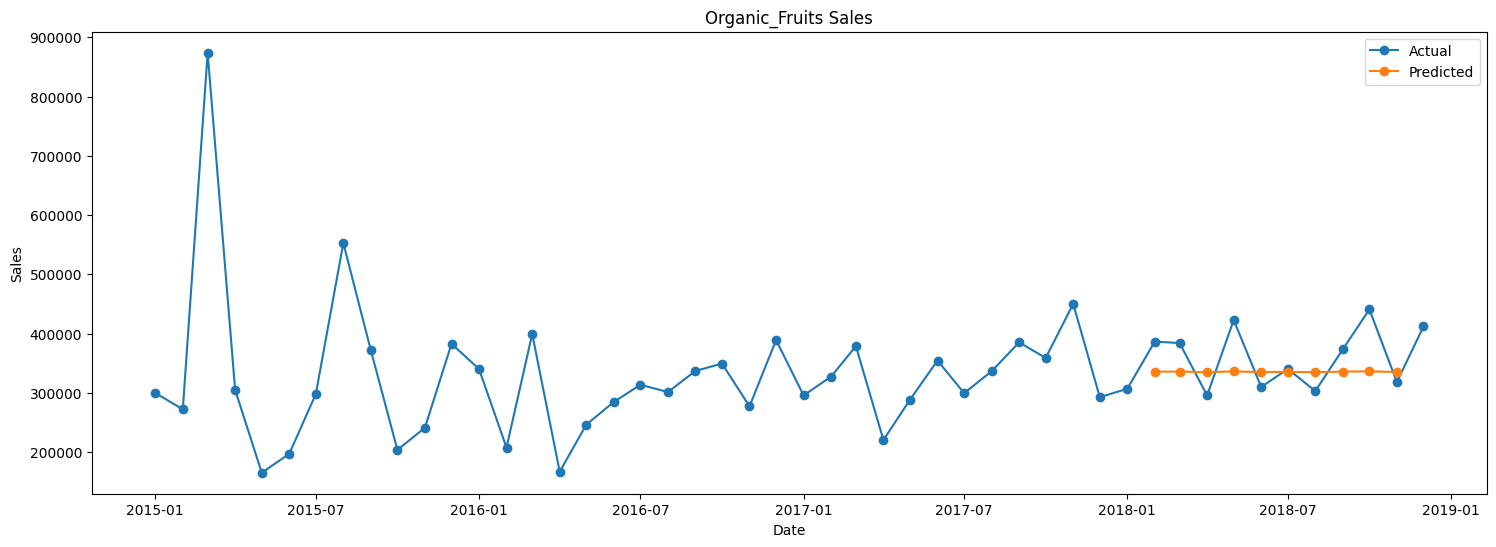

1/1 [==============================] - 0s 39ms/step


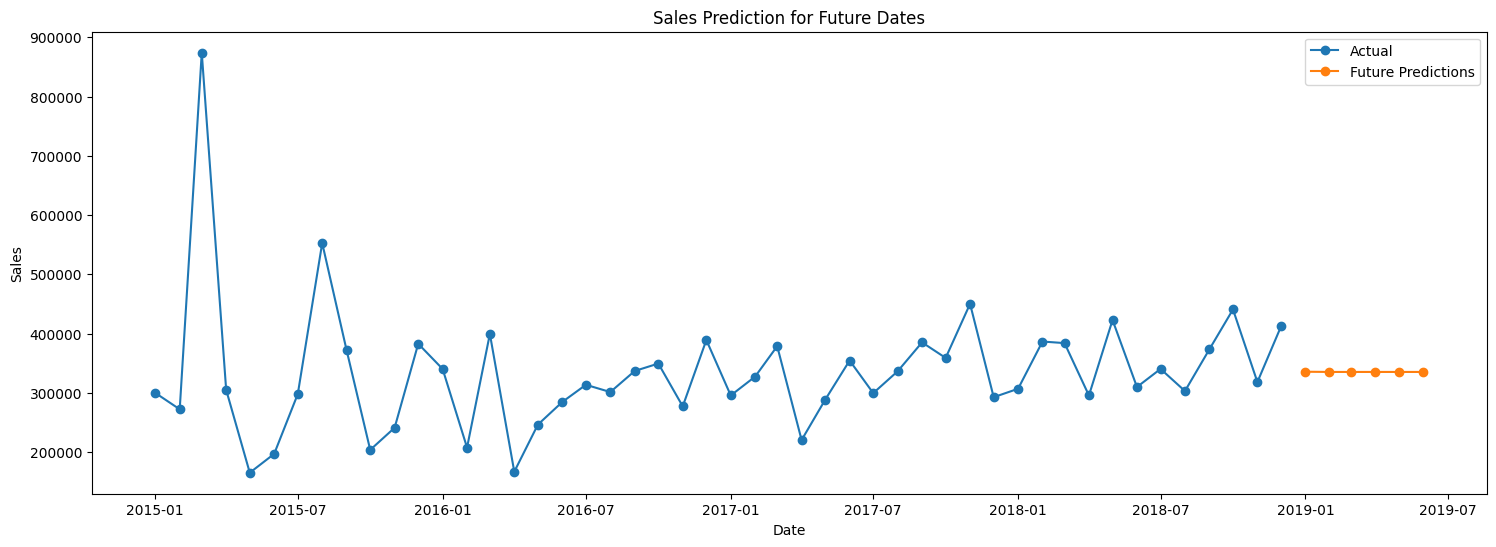

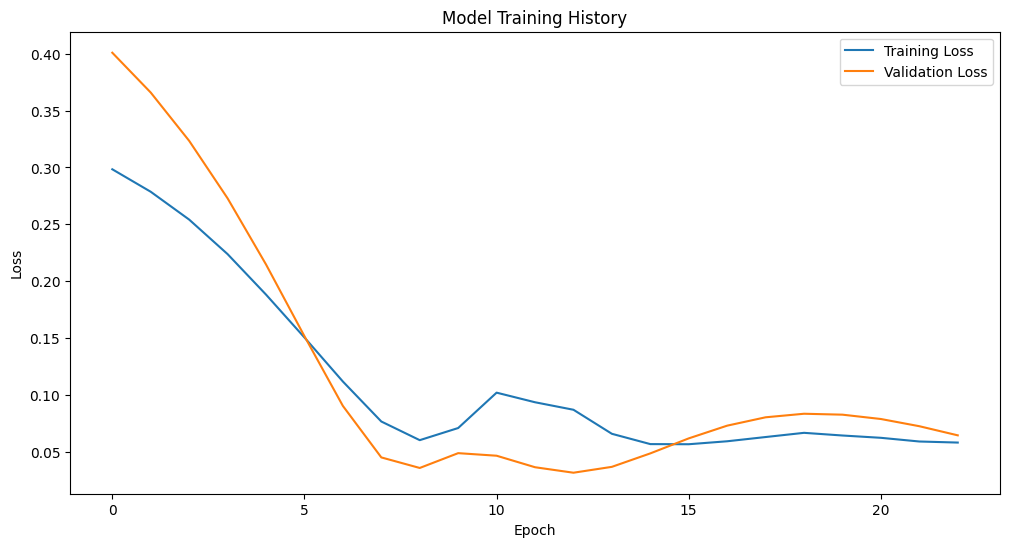

1/1 [==============================] - 0s 48ms/step - loss: 0.0606
Test Loss: 0.060616619884967804


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 260ms/step


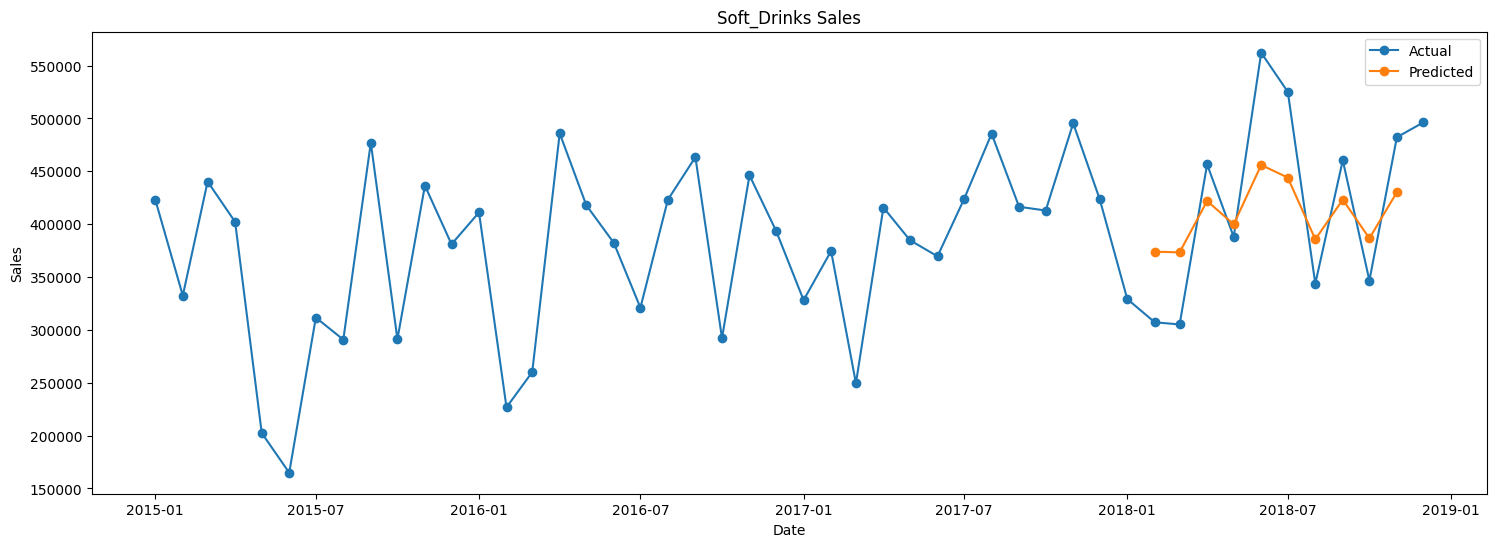

1/1 [==============================] - 0s 33ms/step


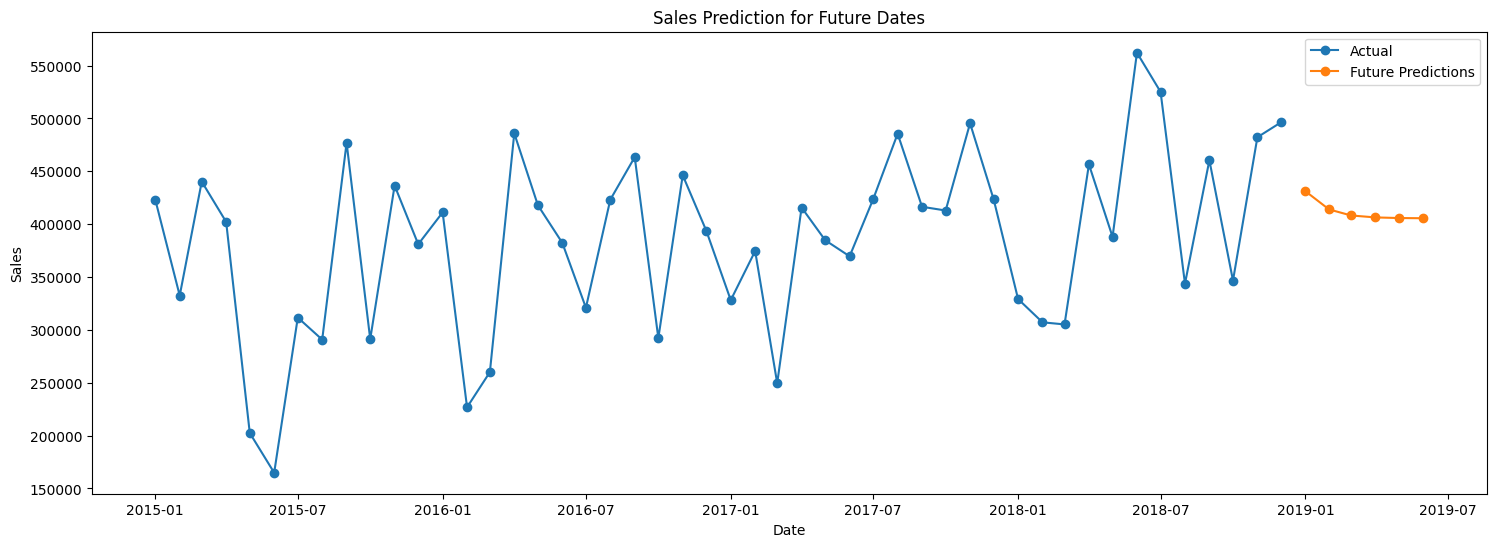

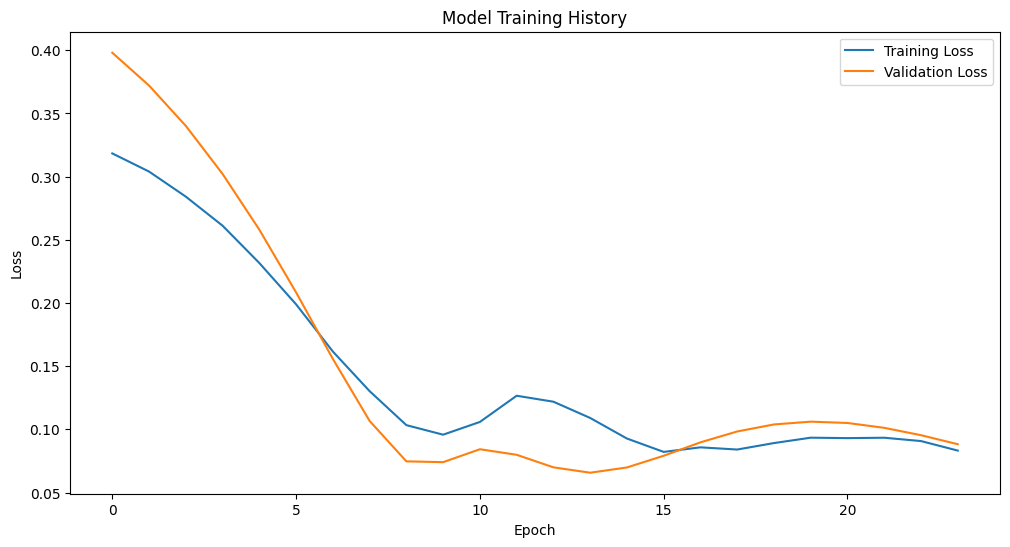

1/1 [==============================] - 0s 40ms/step - loss: 0.0797
Test Loss: 0.07967773824930191


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 276ms/step


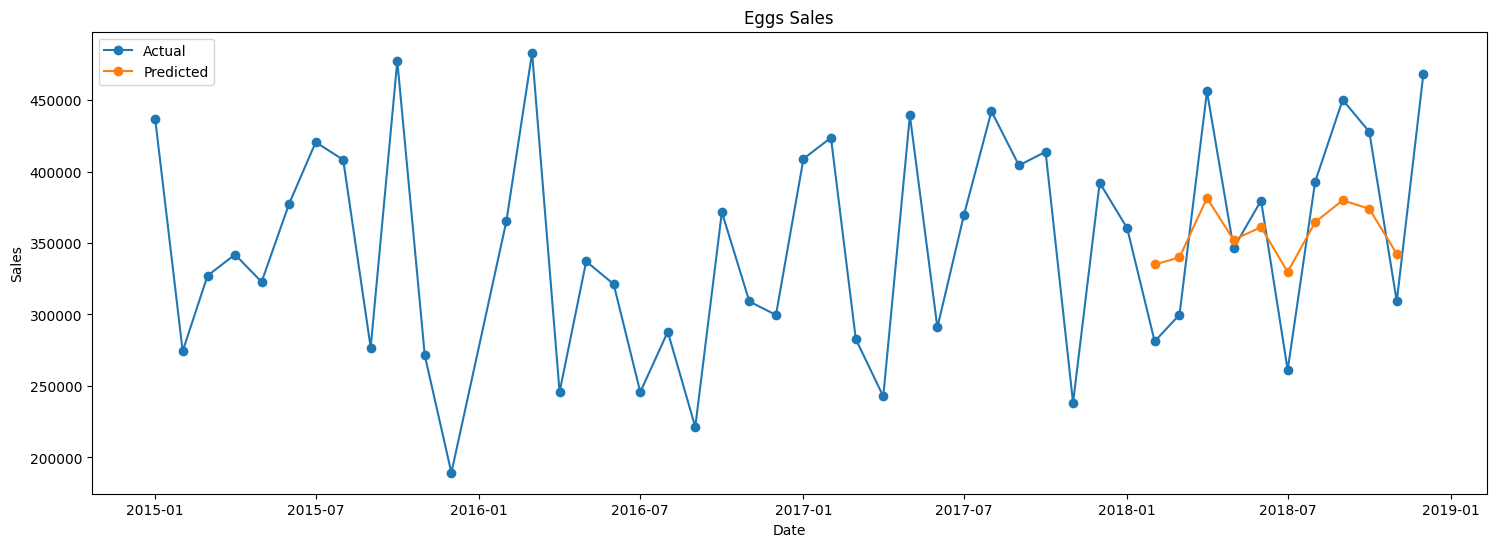

1/1 [==============================] - 0s 33ms/step


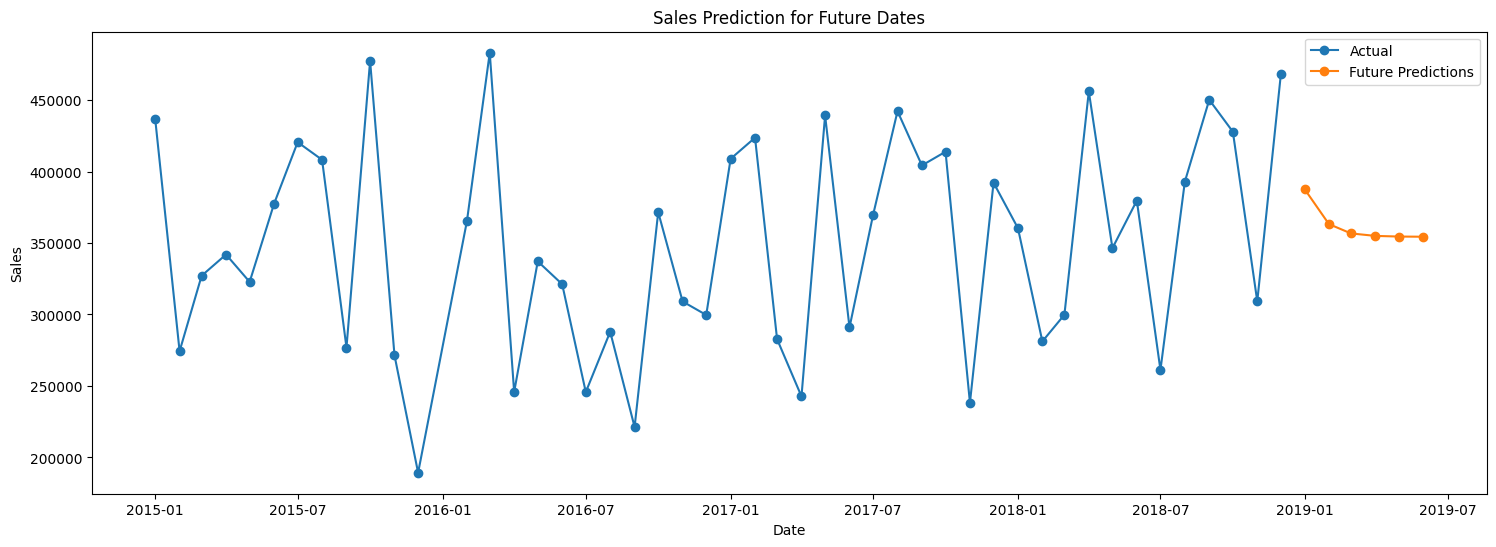

In [58]:
#run the prophet
run_lstm('Overall', sales_df)
run_lstm('Breads',dfs['Breads'])
run_lstm('Cakes',dfs['Cakes'])
run_lstm('Health_Drinks',dfs['Health_Drinks'])
run_lstm('Chocolates',dfs['Chocolates'])
run_lstm('Fish',dfs['Fish'])
run_lstm('Salt',dfs['Salt'])
run_lstm('Noodles',dfs['Noodles'])
run_lstm('Cookies',dfs['Cookies'])
run_lstm('Organic_Vegetables',dfs['Organic_Vegetables'])
run_lstm('Flour',dfs['Flour'])
run_lstm('Edible_Oil',dfs['Edible_Oil'])
run_lstm('Chicken',dfs['Chicken'])
run_lstm('Biscuits',dfs['Biscuits'])
run_lstm('Legumes',dfs['Legumes'])
run_lstm('Spices',dfs['Spices'])
run_lstm('Fresh_Fruits',dfs['Fresh_Fruits'])
run_lstm('Rice',dfs['Rice'])
run_lstm('Meat',dfs['Meat'])
run_lstm('Organic_Staples',dfs['Organic_Staples'])
run_lstm('Fresh_Vegetables',dfs['Fresh_Vegetables'])
run_lstm('Organic_Fruits',dfs['Organic_Fruits'])
run_lstm('Soft_Drinks',dfs['Soft_Drinks'])
run_lstm('Eggs',dfs['Eggs'])